In [0]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import torch.nn.init as torch_init
import torch.nn.functional as func
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os

In [0]:
'''..................help function to show the figure.....................'''

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(22, 3, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


In [0]:
'''.......................basci information................................'''

class Config():
    training_dir = "./train_pic/"
    testing_dir = "./test_pic/"
    train_batch_size = 200
    train_number_epochs = 100


In [0]:
'''.................read the data........................................'''  
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")        
 
        if self.should_invert:
            img0 = PIL.ImageOps.mirror(img0)
            img1 = PIL.ImageOps.mirror(img1)
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
#        return len(self.imageFolderDataset.imgs)
        return Config.train_batch_size


In [0]:
'''.......................SNN function....................................'''
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
       
        # conv1: 1 input channel, 12 output channels, [8x8] kernel size
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7)
        # Add batch-normalization to the outputs of conv1
        # Initialized weights using the Xavier-Normal method
        torch_init.xavier_normal_(self.conv1.weight)
        
#        self.pool = nn.MaxPool2d(kernel_size= 2, stride= 2)
        #TODO: Fill in the remaining initializations replacing each '_' with
        # the necessary value based on the provided specs for each layer

        #TODO: conv2: X input channels, 10 output channels, [8x8] kernel, initialization: xavier
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
        torch_init.xavier_normal_(self.conv2.weight)
        
        self.pool = nn.MaxPool2d(kernel_size= 2, stride= 2)
        #TODO: conv3: X input channels, 8 output channels, [6x6] kernel, initialization: xavier
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5)
        torch_init.xavier_normal_(self.conv3.weight)

        # Define 2 fully connected layers:
        #TODO: Use the value you computed in Part 1, Question 4 for fc1's in_features, initialization: xavier
        self.fc1 = nn.Linear(in_features= 2304, out_features=512)
#        self.fc1_normed = nn.BatchNorm1d(64)
        torch_init.xavier_normal_(self.fc1.weight)
#
#        #TODO: Output layer: what should out_features be?
        self.fc2 = nn.Linear(in_features= 512, out_features= 2)
        torch_init.xavier_normal_(self.fc2.weight)
#        
#        

    def forward_once(self, batch):
        # Apply first convolution, followed by ReLU non-linearity; 
        # use batch-normalization on its outputs
                # padding

        batch = func.relu(self.conv1(batch))
        batch = self.pool(batch)
#        print(batch.shape)

        # Apply conv2 and conv3 similarly
        batch = func.relu(self.conv2(batch))
#        print(batch.shape)
        
        batch = func.relu(self.conv3(batch))
#        print(batch.shape)    
        

        # Reshape the output of the conv3 to pass to fully-connected layer
        batch = batch.view(-1, self.num_flat_features(batch))
        
        # Connect the reshaped features of the pooled conv3 to fc1
        batch = self.fc1(batch)
        
       # Connect fc1 to fc2 - this layer is slightly different than the rest (why?)
        batch = self.fc2(batch)


        # Return the class predictions
        
        #TODO: apply an activition function to 'batch'
        output = torch.sigmoid(batch)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
    def num_flat_features(self, inputs):
        
        # Get the dimensions of the layers excluding the inputs
        size = inputs.size()[1:]
        # Track the number of features
        num_features = 1
        
        for s in size:
            num_features *= s
        
        return num_features


In [0]:
'''......................Contrastive Loss...............................'''
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive



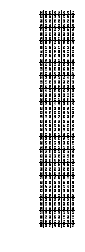

[[0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.

In [0]:
'''.................show the training set and the label....................'''   
folder_dataset = dset.ImageFolder(root=Config.training_dir)
valid_dataset = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((28,28)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [0]:
'''.............................test...............................'''

folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((28,28)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)


In [0]:
def test():
    total_loss = 0
    dataiter = iter(test_dataloader)
    x0,_,_ = next(dataiter)

    #
    #x0 = Image.open('/Users/luodi/Desktop/271B/PROJECT/bird.png')
    #x0 = x0.convert("L")
    #p = transforms.Compose([transforms.Resize(100),transforms.ToTensor()])
    #x0 = p(x0)
    #x0 = x0.unsqueeze(0)

    for i in range(10):
    #    x1 = Image.open('/Users/luodi/Desktop/271B/PROJECT/pic/testdata/%d.png'%(i))
    #    x1 = x1.convert("L")
    #    x1 = p(x1)
    #    x1 = x1.unsqueeze(0)

        _,x1,label_val = next(dataiter)

        concatenated = torch.cat((x0,x1),0)   
        output0_val,output1_val = net(Variable(x0).cuda(),Variable(x1).cuda())
        loss_val = criterion(output0_val,output1_val,label_val)
        total_loss += loss_val
    return total_loss/10
#         euclidean_distance = F.pairwise_distance(output1, output2)
#         imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [0]:
'''....................train...............................'''

train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005)

counter = []
loss_history = [] 
loss_history_val = []
iteration_number= 0

for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
    counter.append(epoch)
    loss_history.append(loss_contrastive.item())
    
    # validation set
#     loss_val = test()
#     loss_history_val.append(loss_val)
    
show_plot(counter,loss_history)
show_plot(counter,loss_history_val)
save_dir = './'
save_path = os.path.join(save_dir,'model')
torch.save(net.state_dict(), save_path)


In [0]:
# x0 = Image.open('./train_pic/bird/0.png')
# x0 = x0.convert("L")
# p = transforms.Compose([transforms.Resize((28, 28)),transforms.ToTensor()])
# x0 = p(x0)
# x0 = x0.unsqueeze(0)

# x1 = Image.open('./train_pic/bird/1.png')
# x1 = x1.convert("L")
# x1 = p(x1)
# x1 = x1.unsqueeze(0)
# concatenated = torch.cat((x0,x1),0)   
# output0, output1 = net(Variable(x0).cuda(),Variable(x1).cuda())
# loss_val = criterion(output0,output1,0)
# print(loss_val)

# euclidean_distance = F.pairwise_distance(output1, output2)
# imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

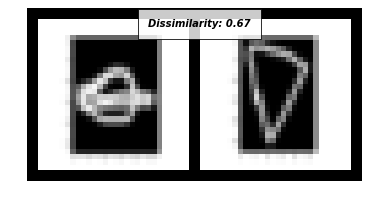

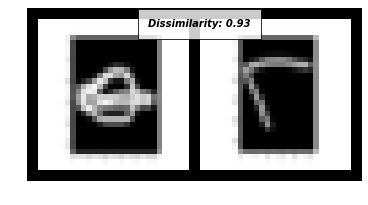

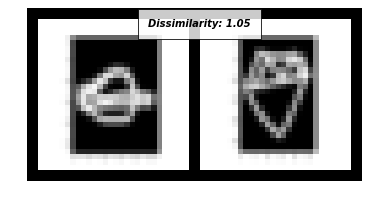

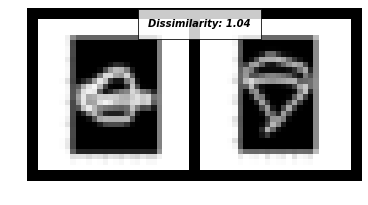

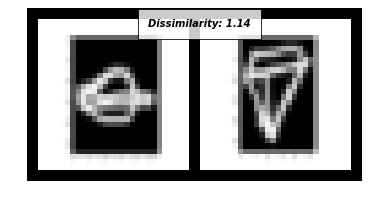

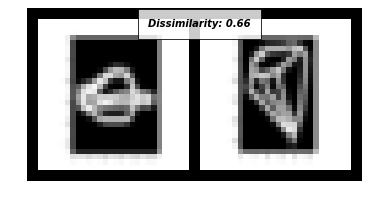

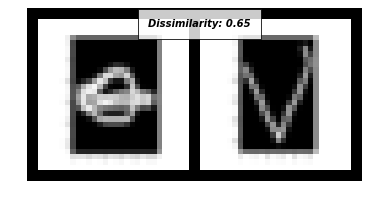

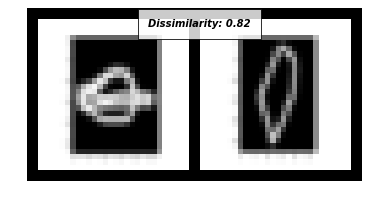

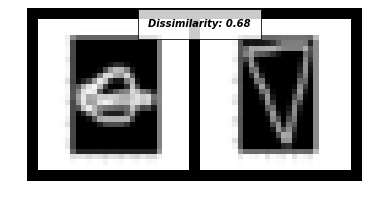

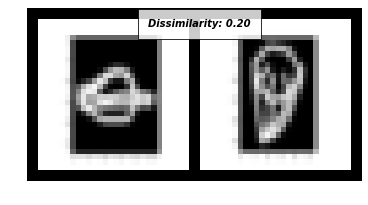

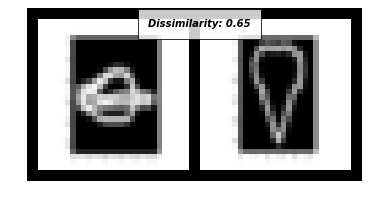

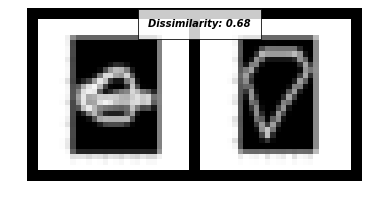

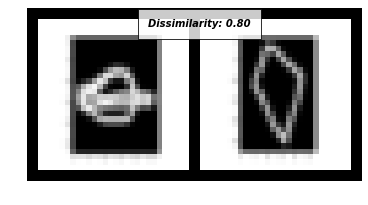

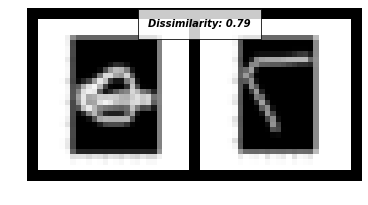

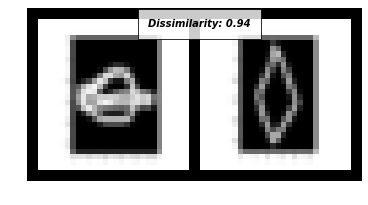

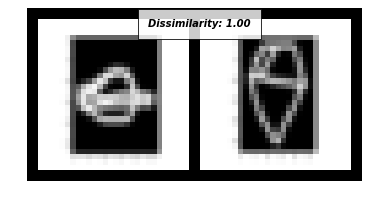

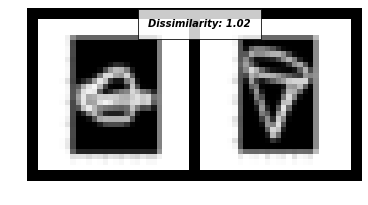

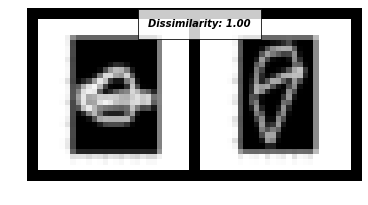

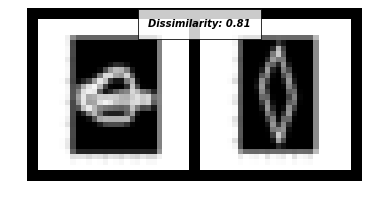

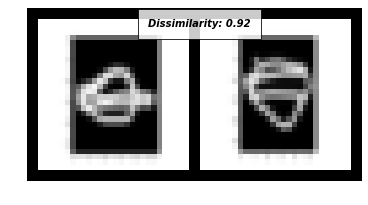

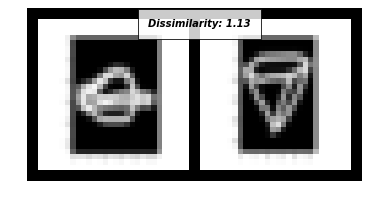

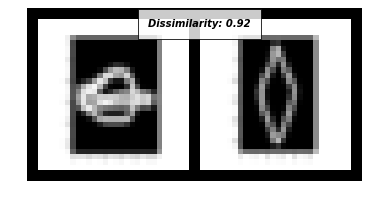

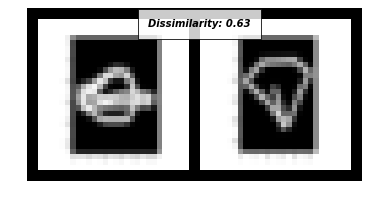

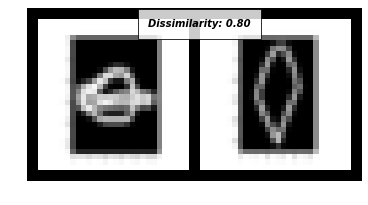

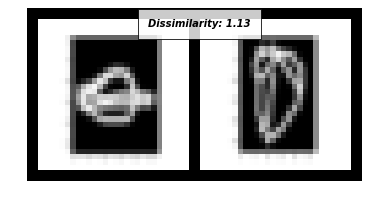

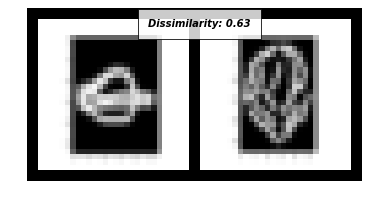

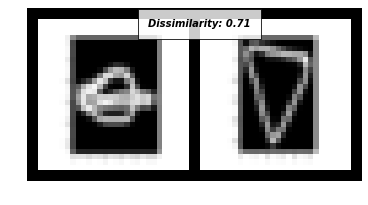

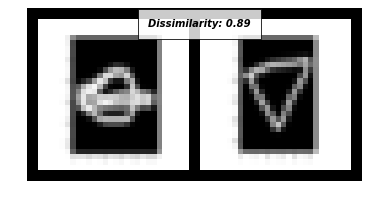

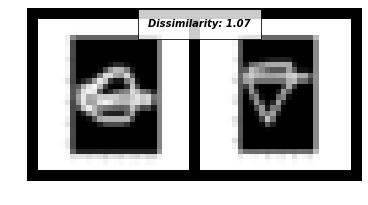

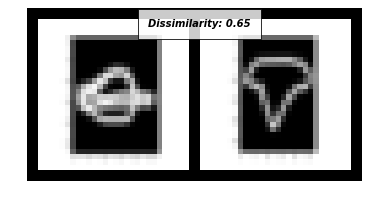

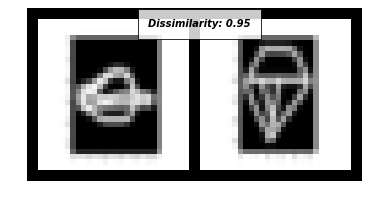

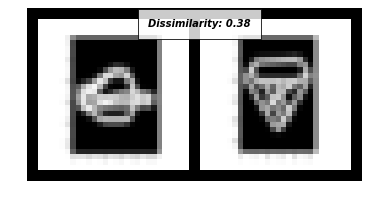

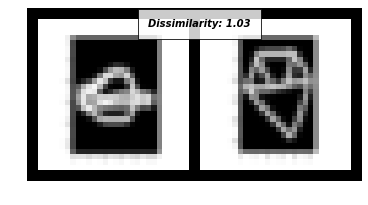

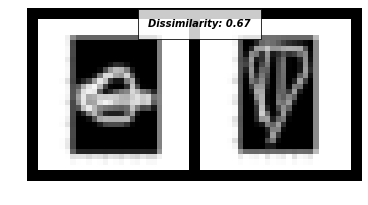

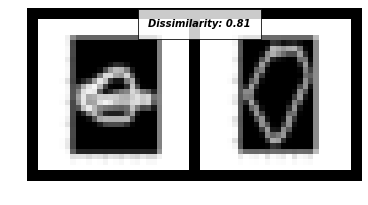

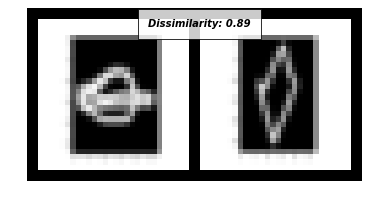

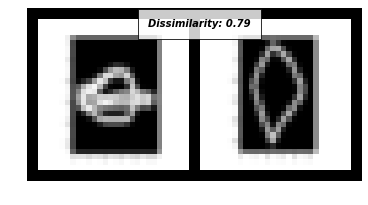

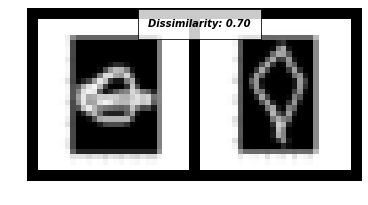

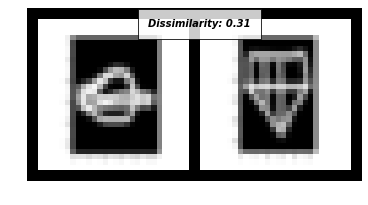

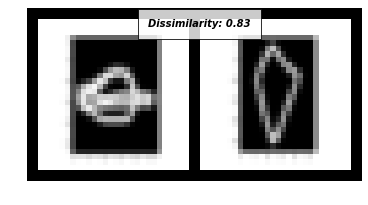

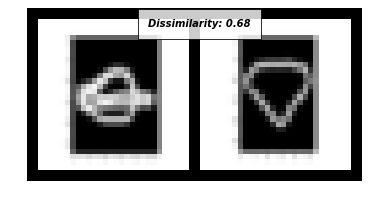

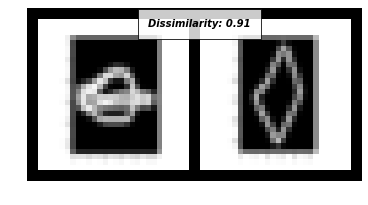

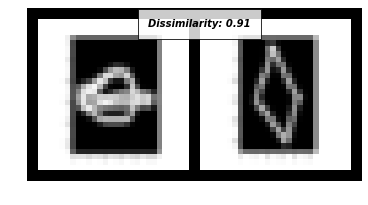

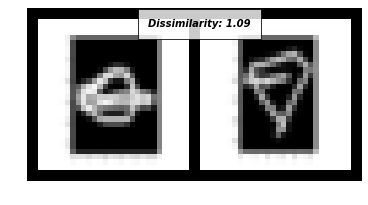

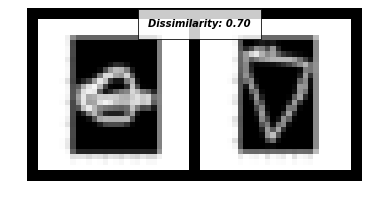

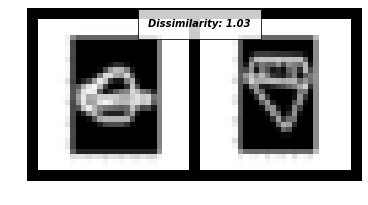

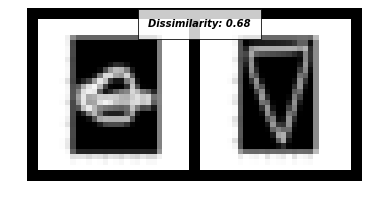

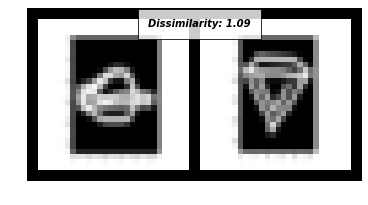

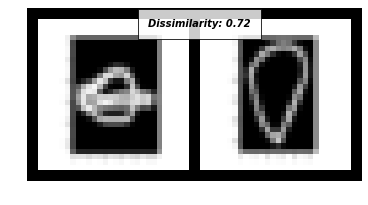

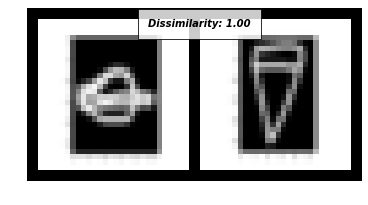

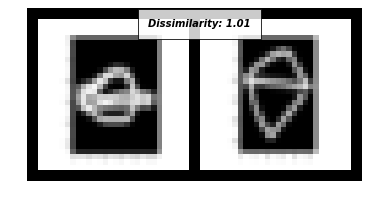

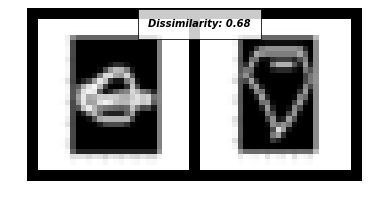

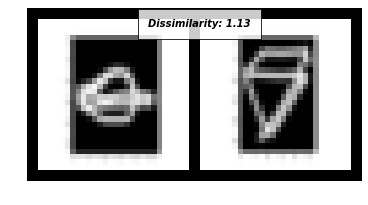

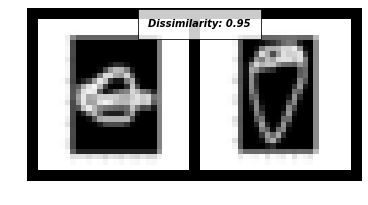

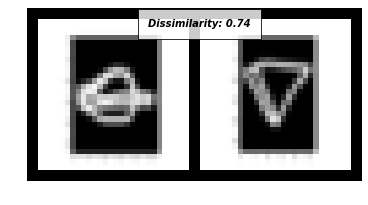

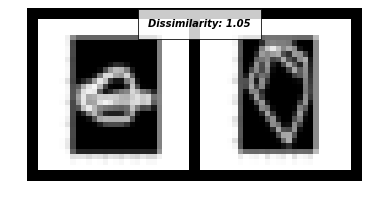

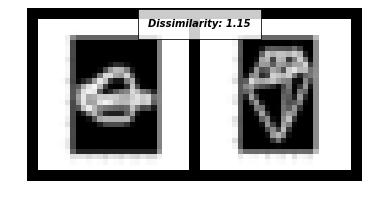

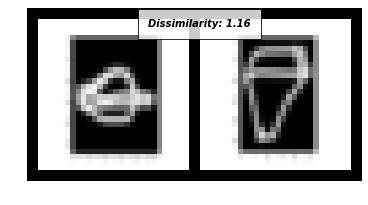

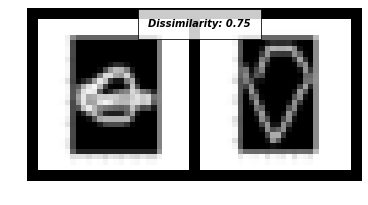

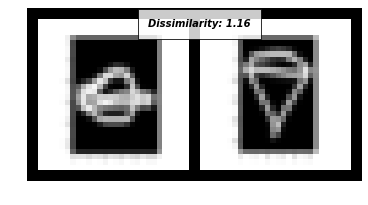

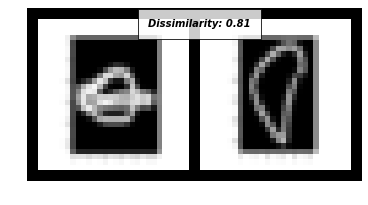

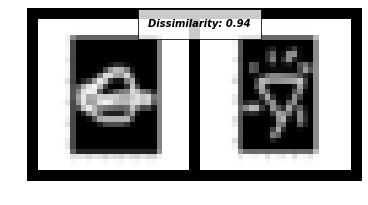

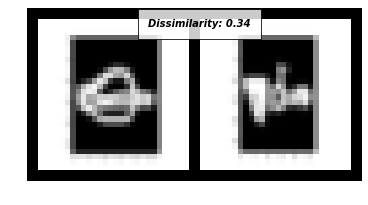

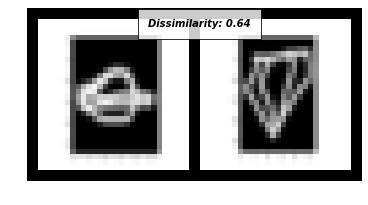

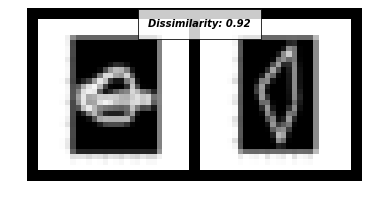

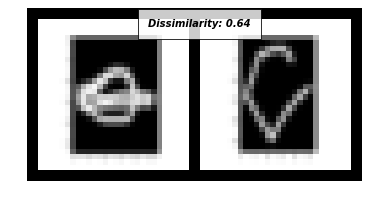

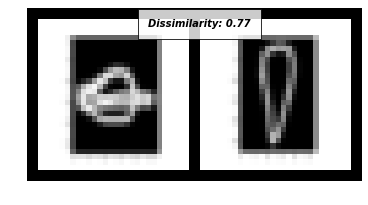

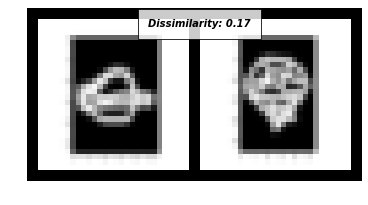

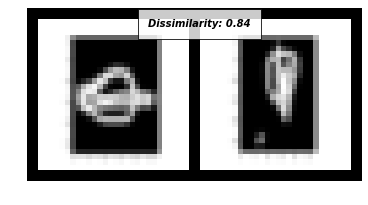

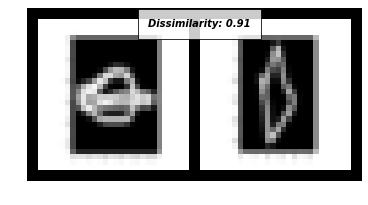

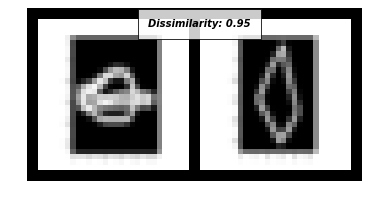

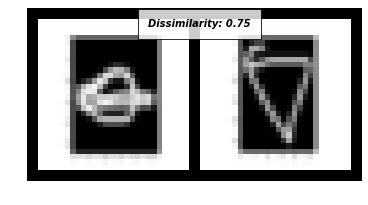

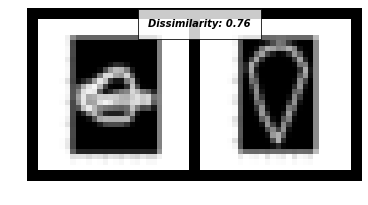

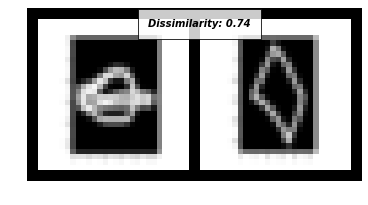

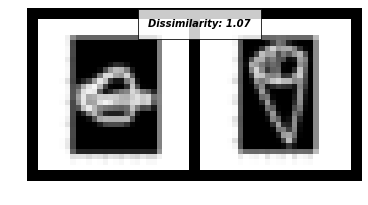

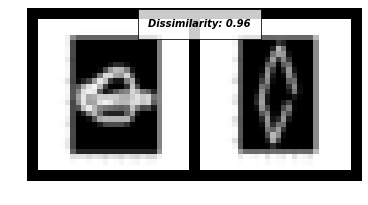

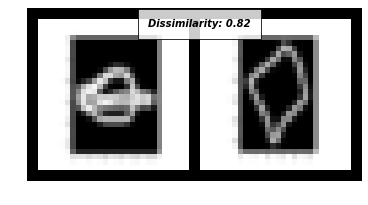

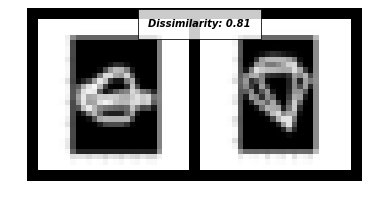

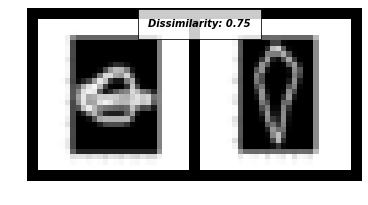

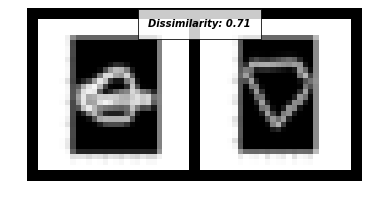

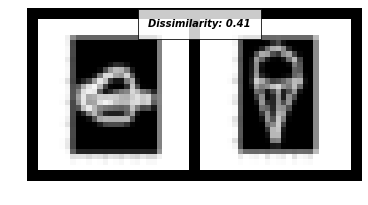

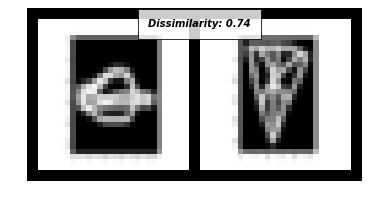

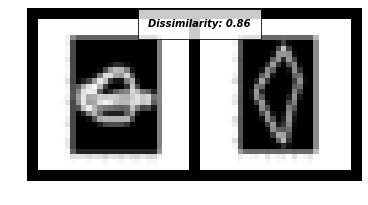

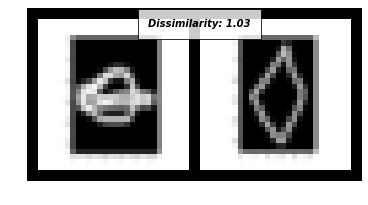

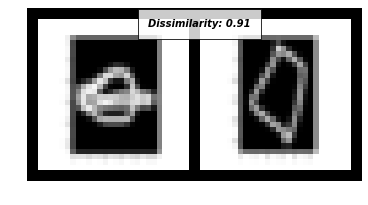

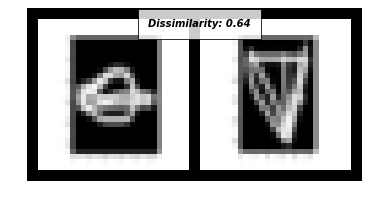

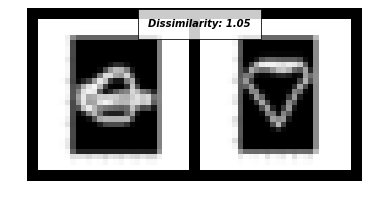

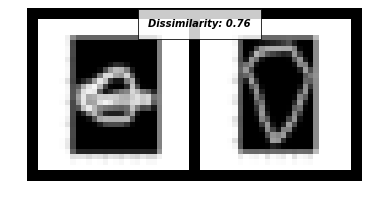

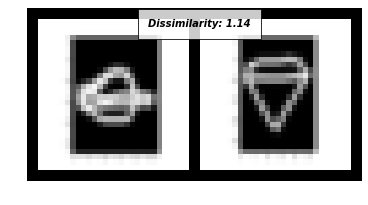

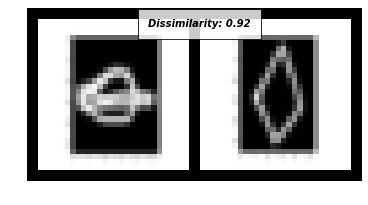

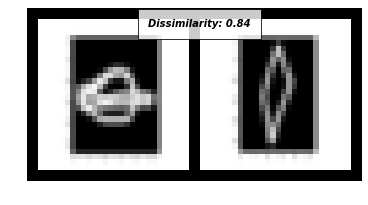

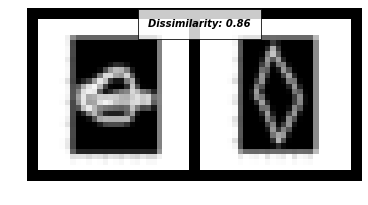

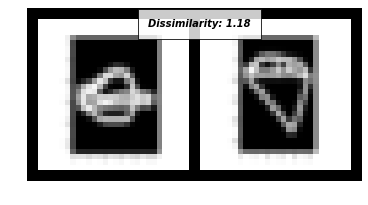

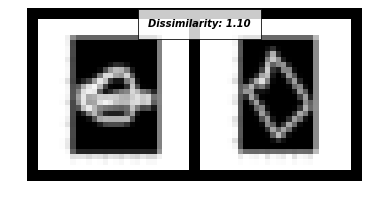

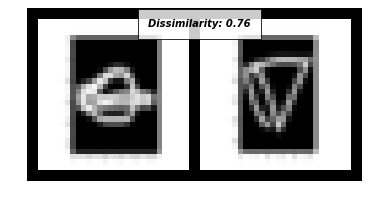

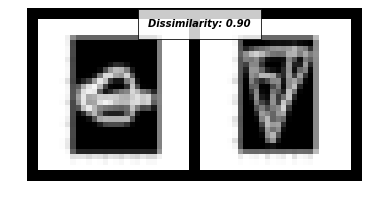

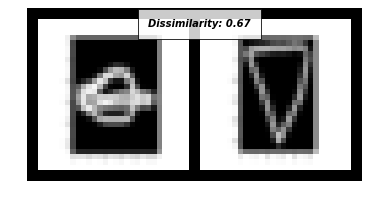

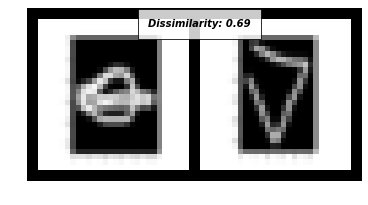

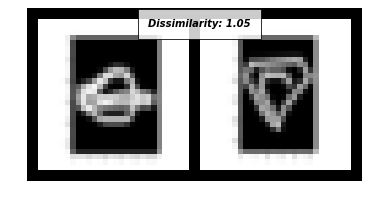

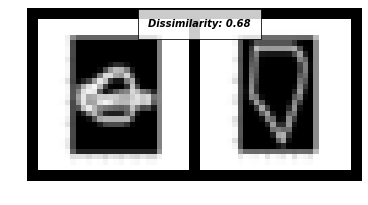

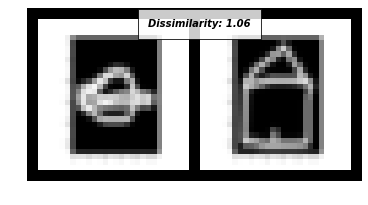

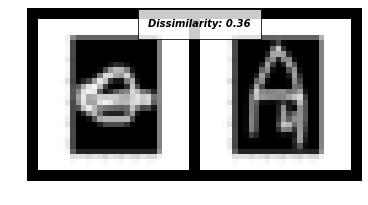

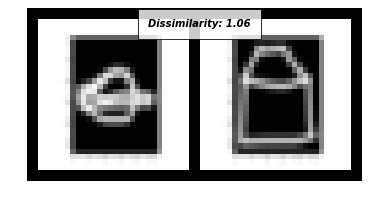

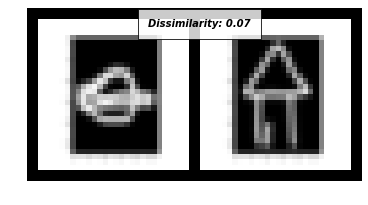

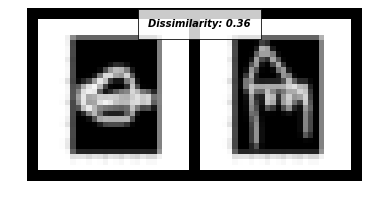

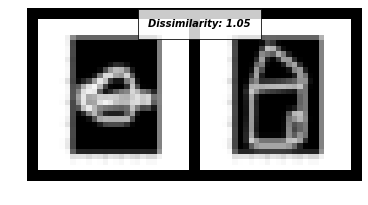

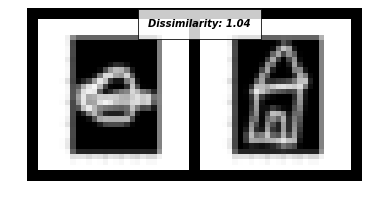

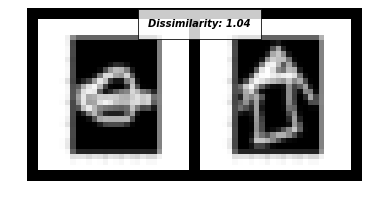

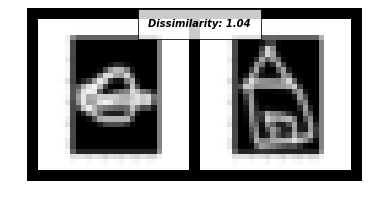

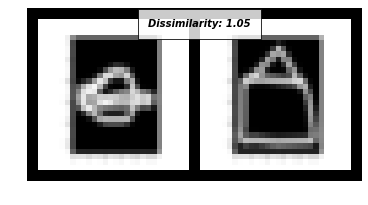

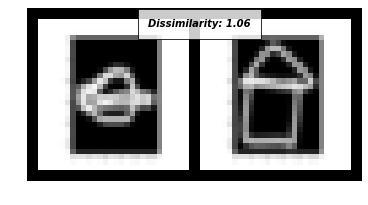

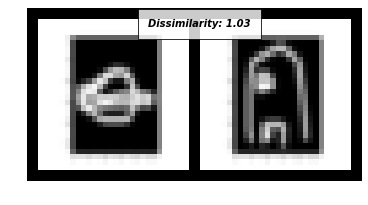

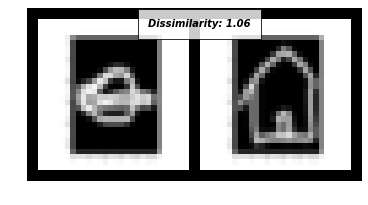

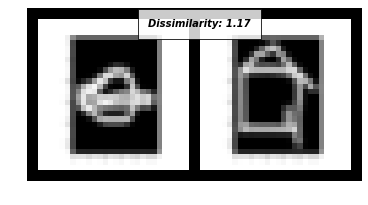

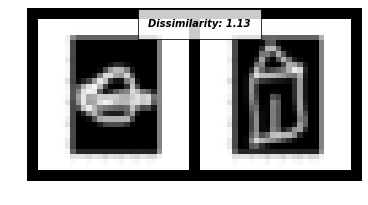

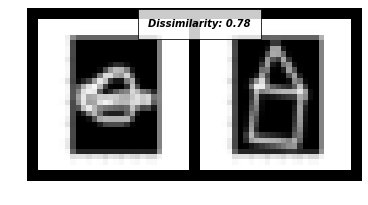

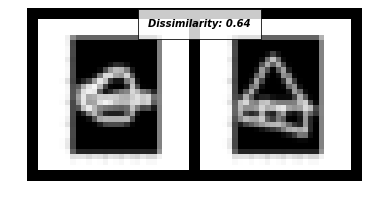

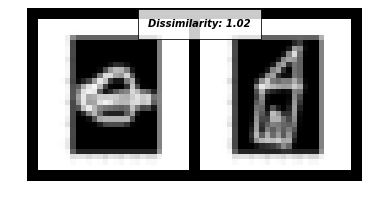

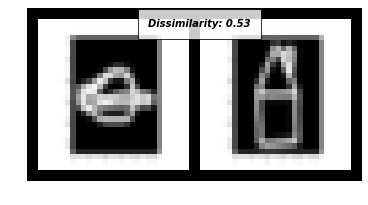

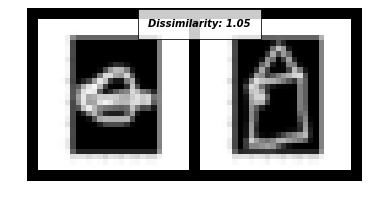

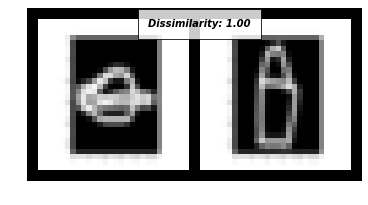

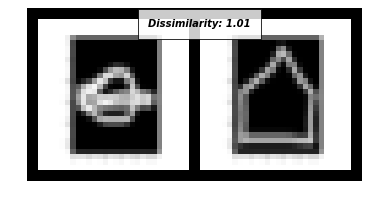

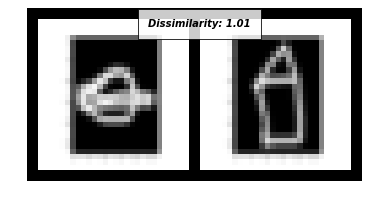

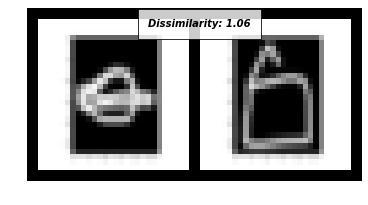

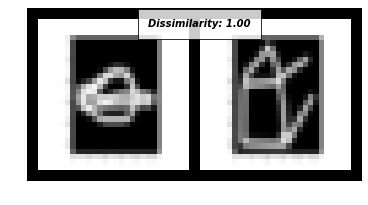

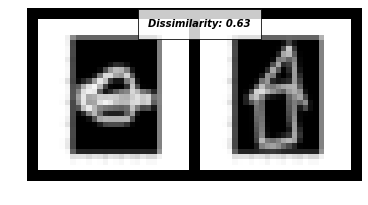

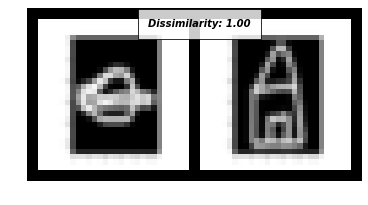

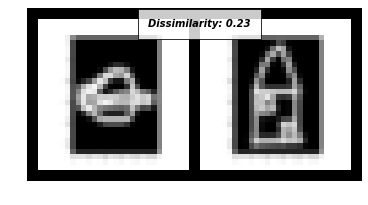

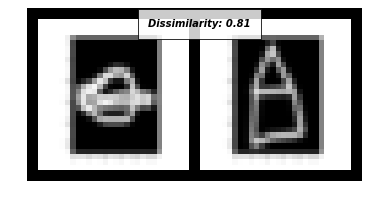

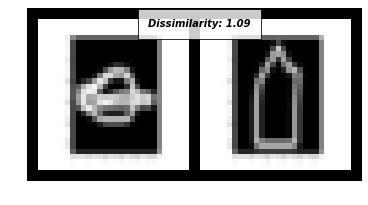

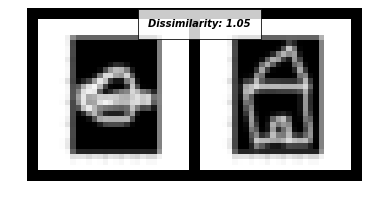

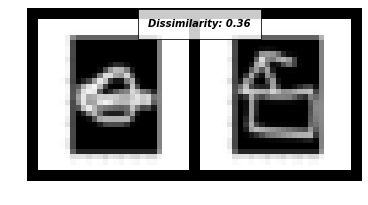

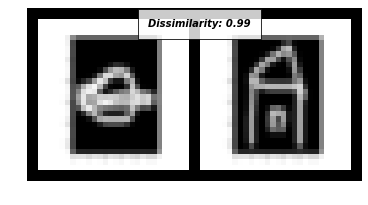

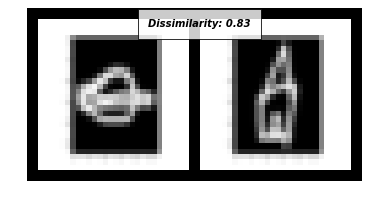

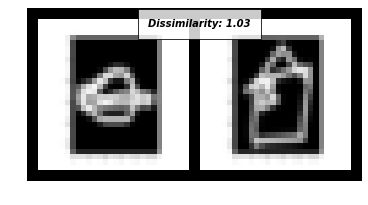

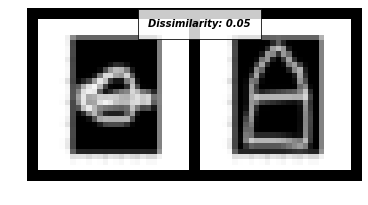

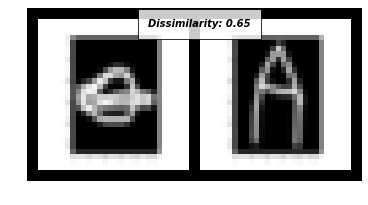

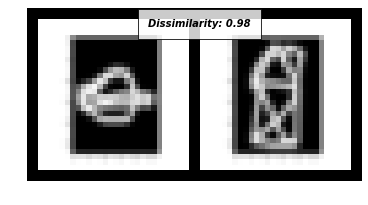

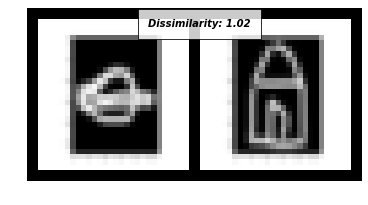

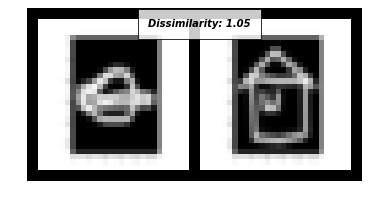

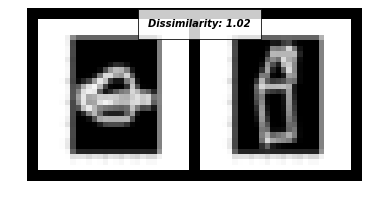

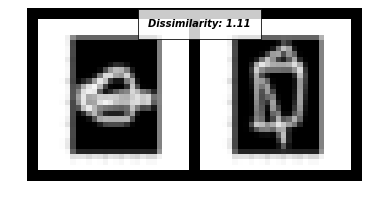

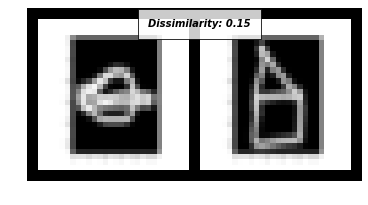

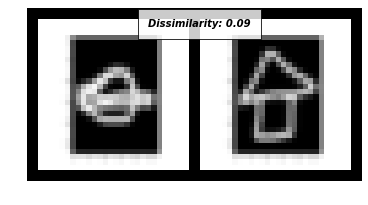

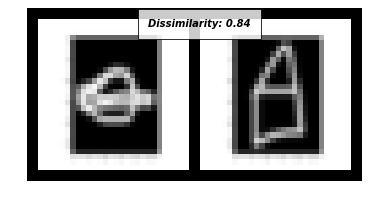

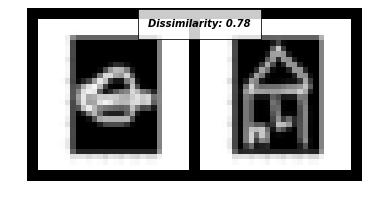

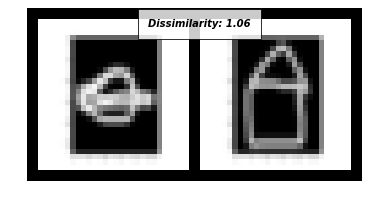

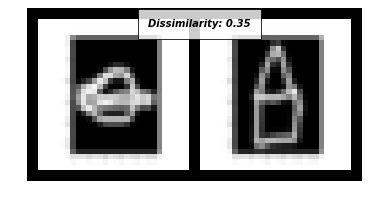

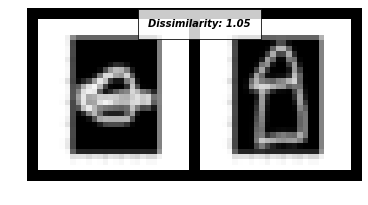

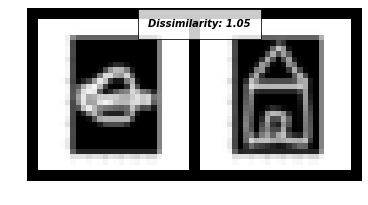

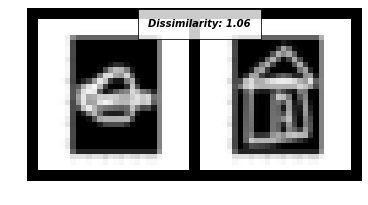

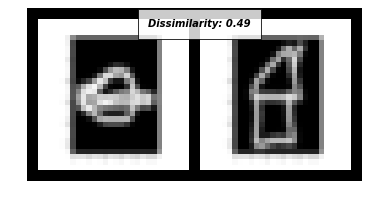

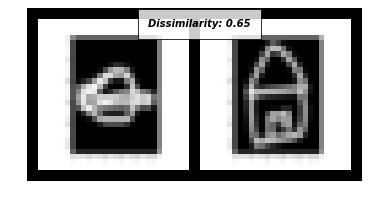

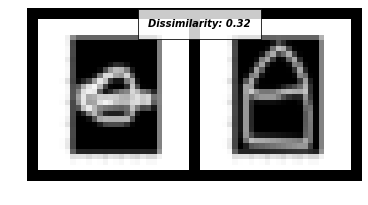

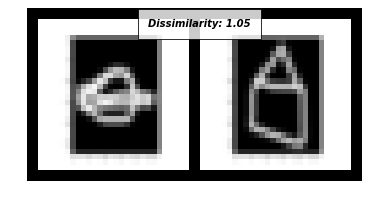

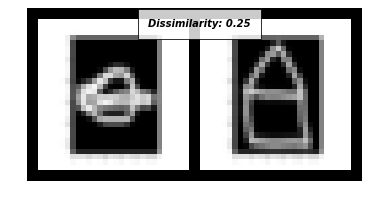

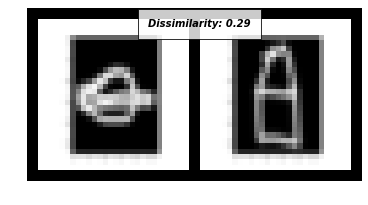

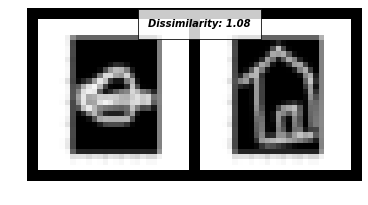

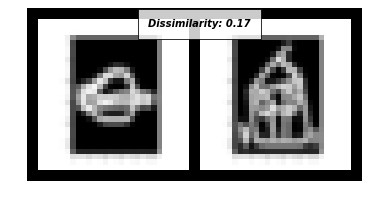

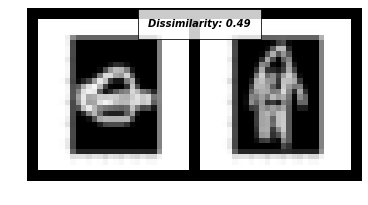

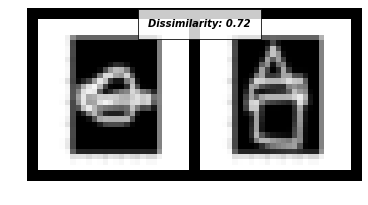

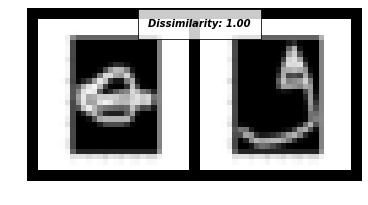

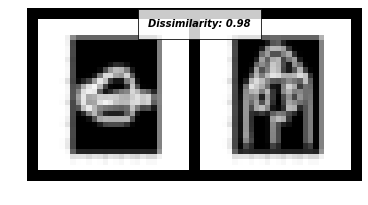

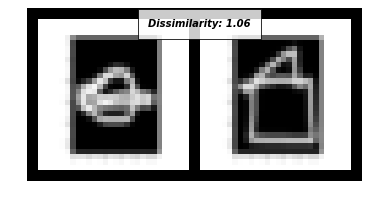

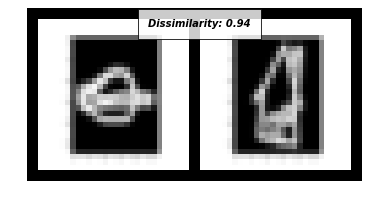

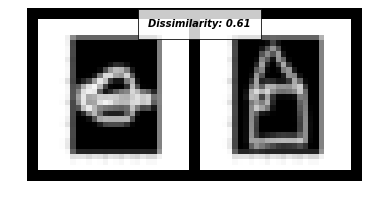

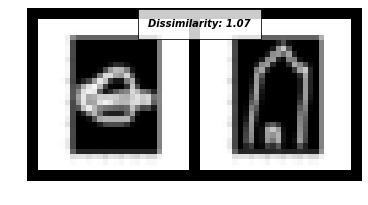

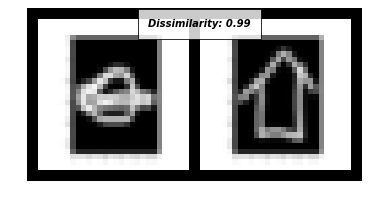

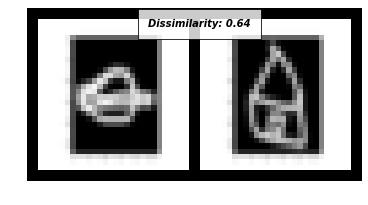

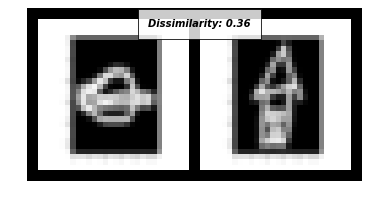

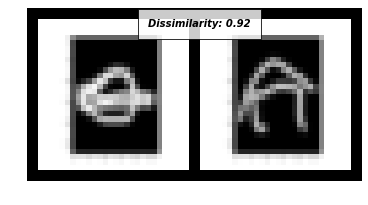

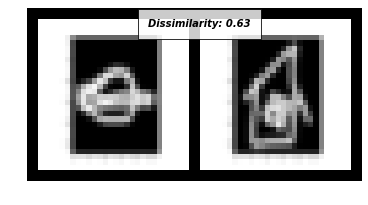

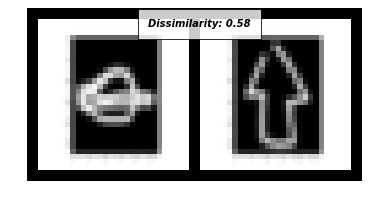

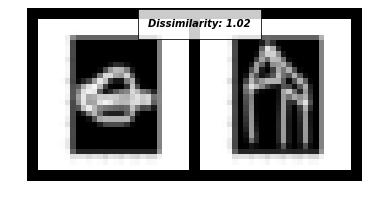

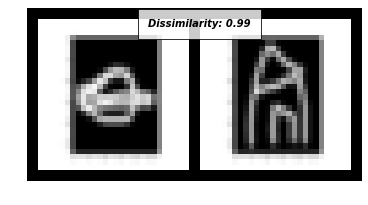

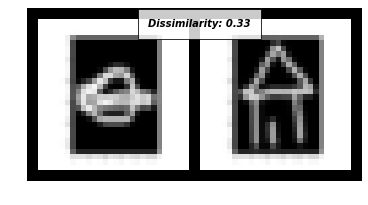

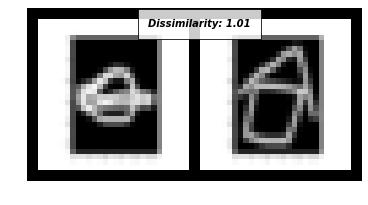

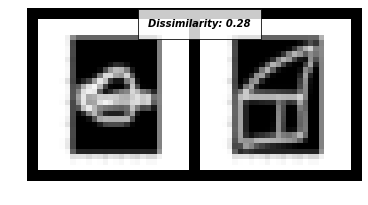

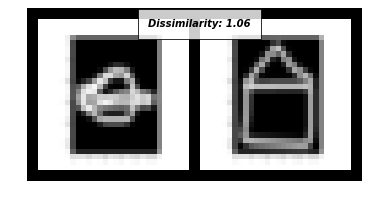

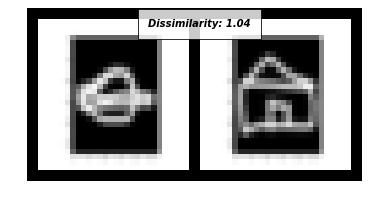

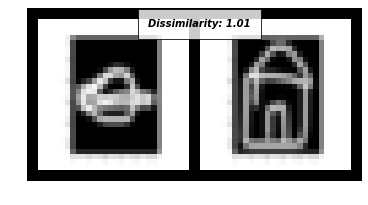

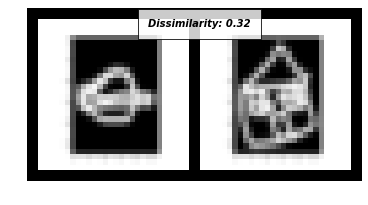

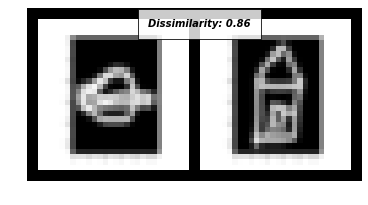

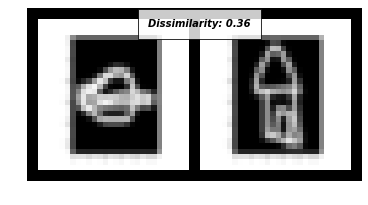

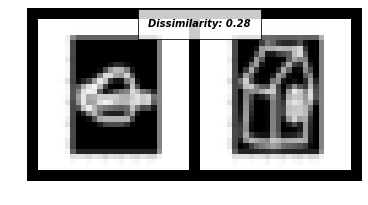

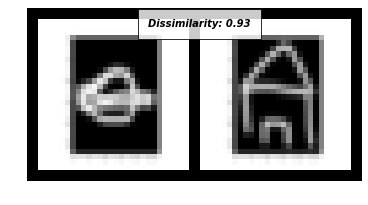

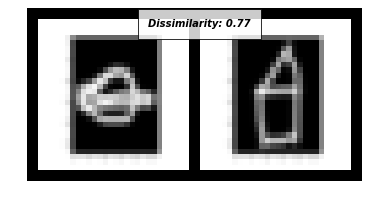

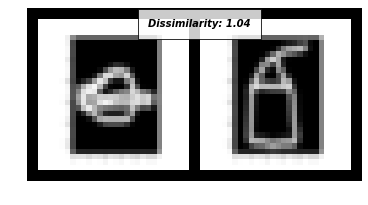

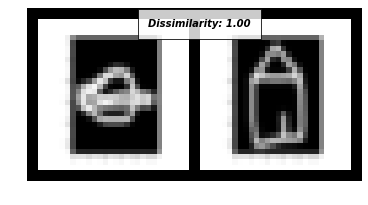

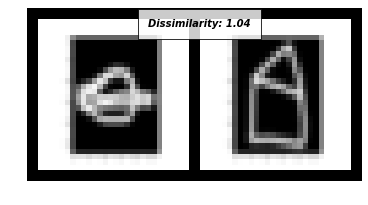

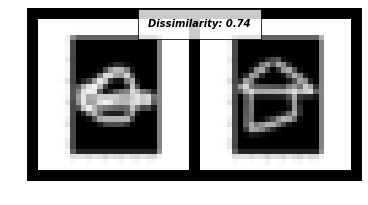

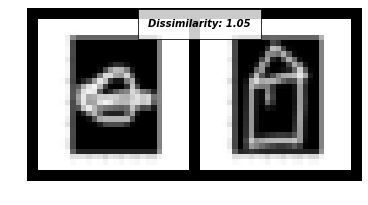

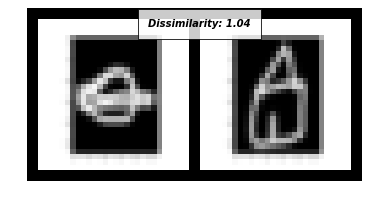

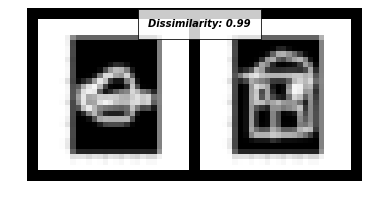

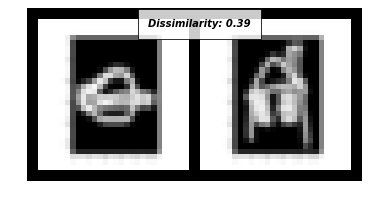

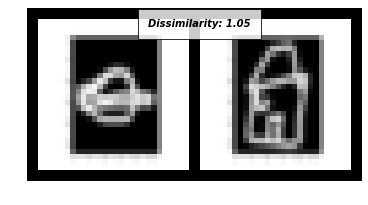

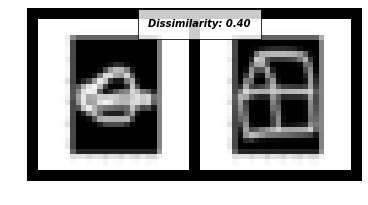

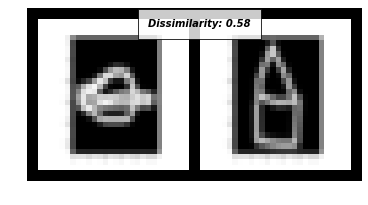

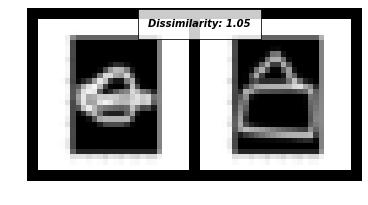

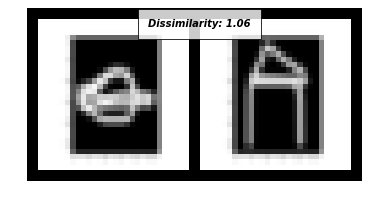

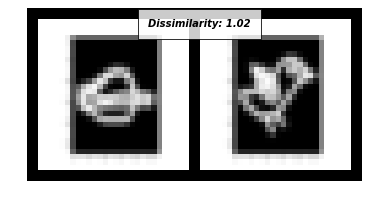

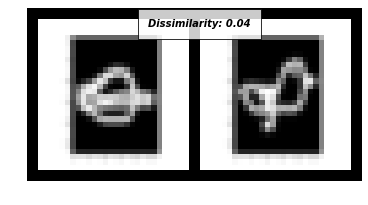

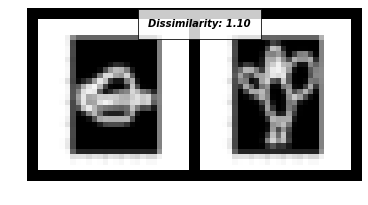

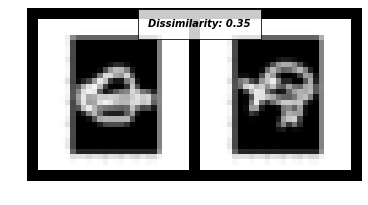

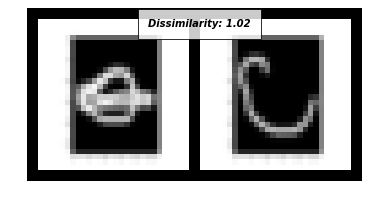

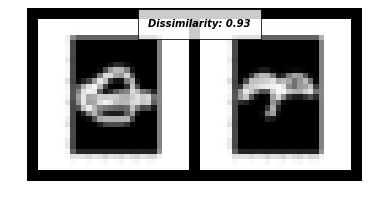

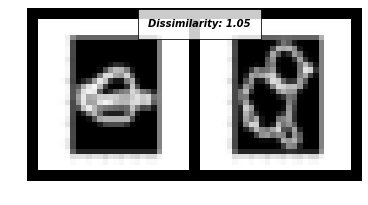

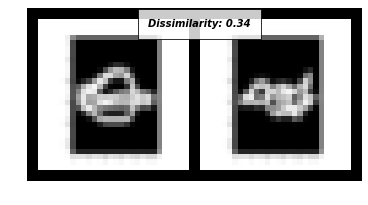

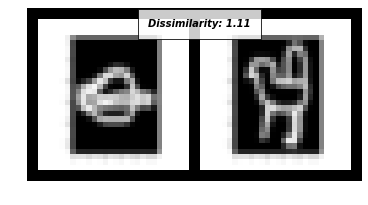

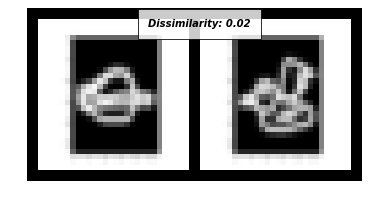

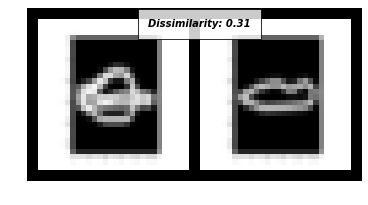

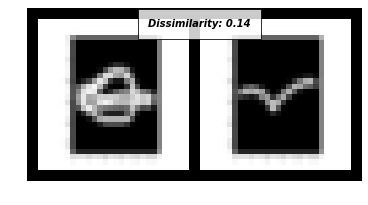

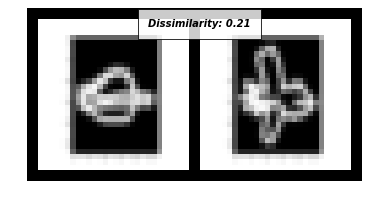

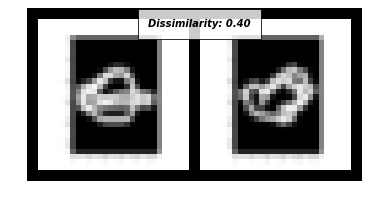

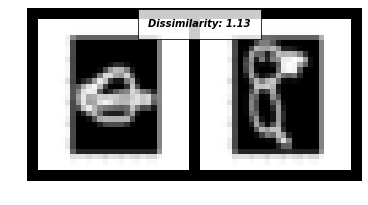

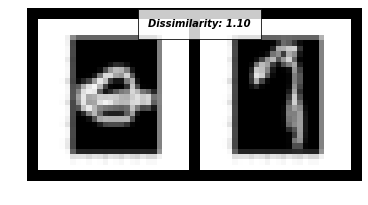

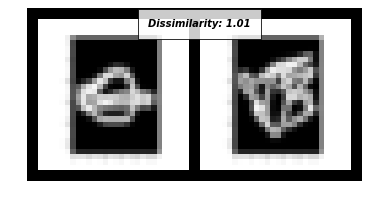

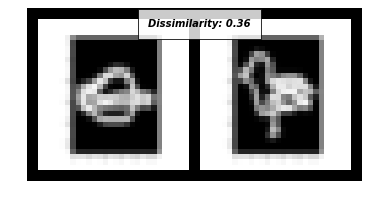

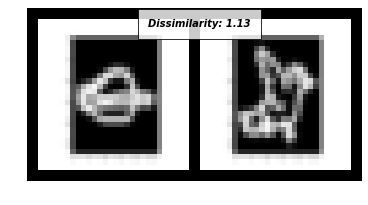

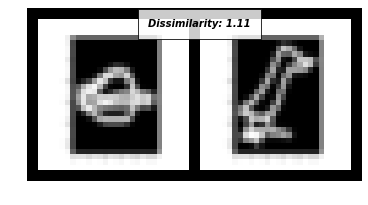

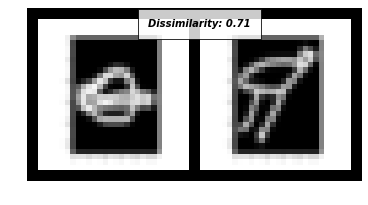

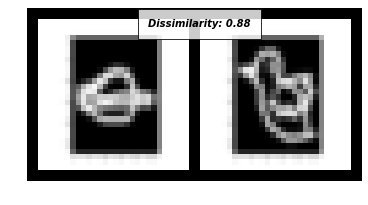

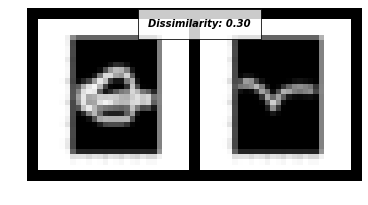

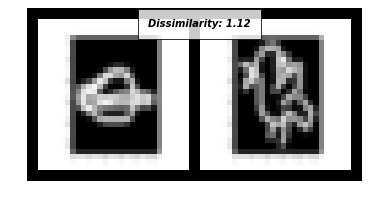

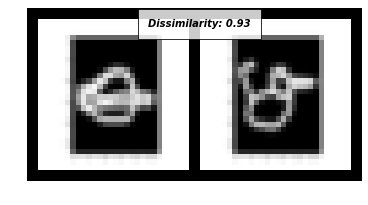

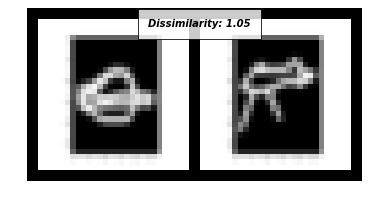

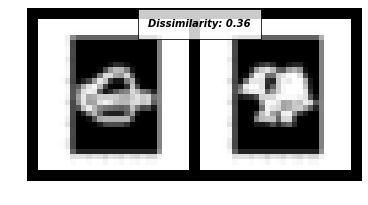

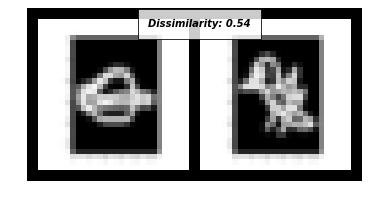

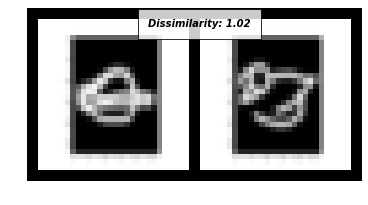

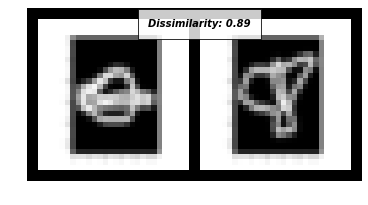

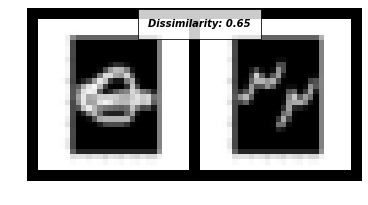

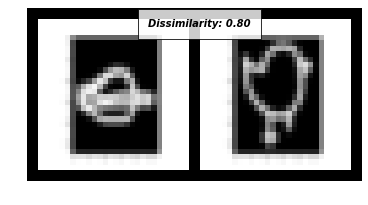

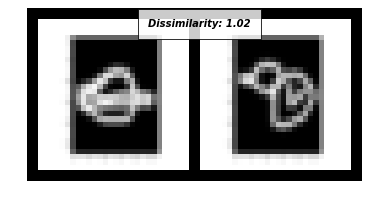

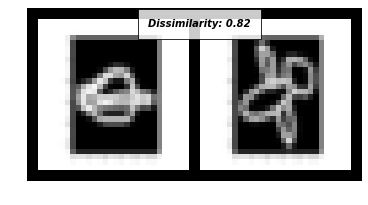

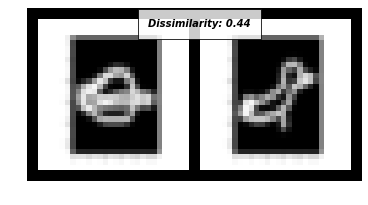

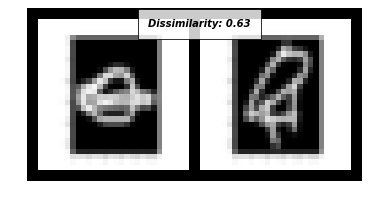

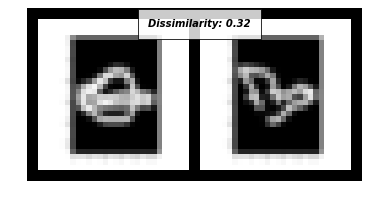

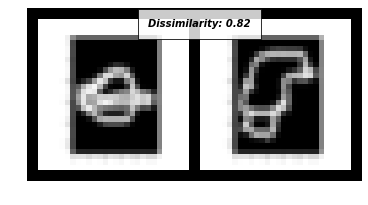

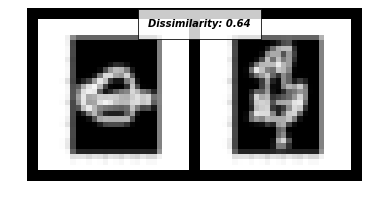

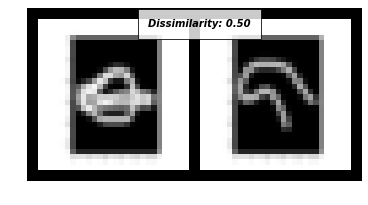

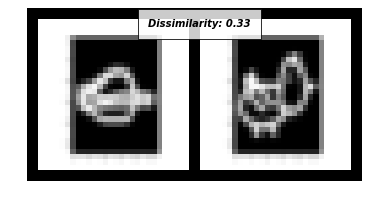

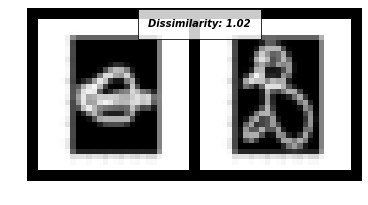

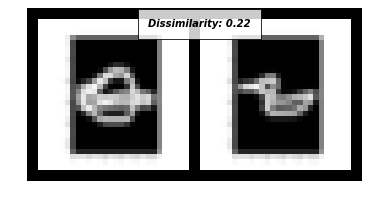

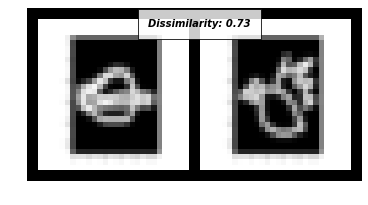

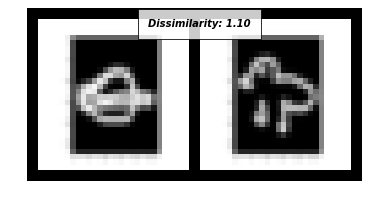

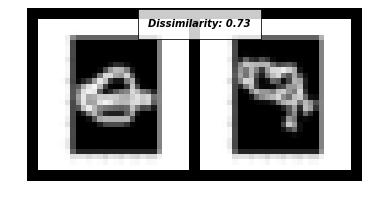

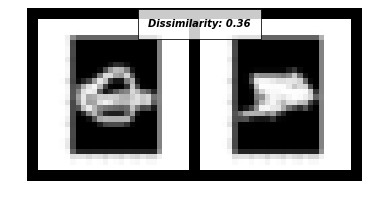

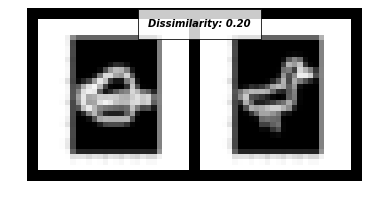

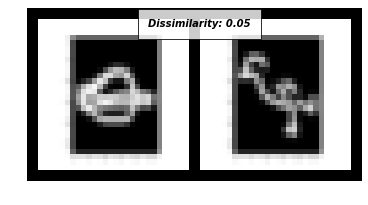

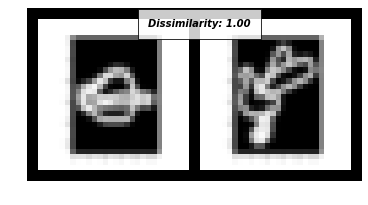

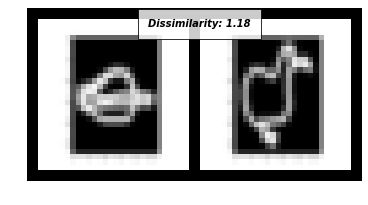

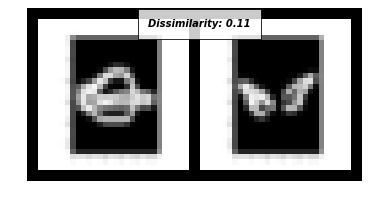

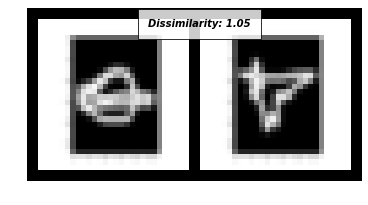

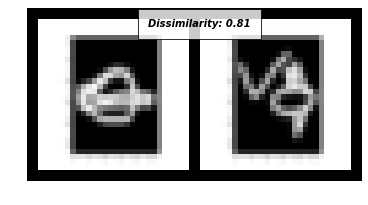

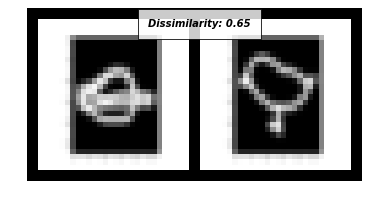

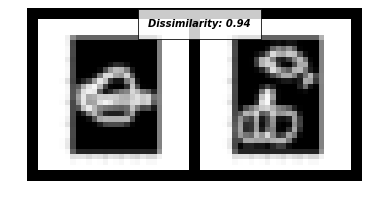

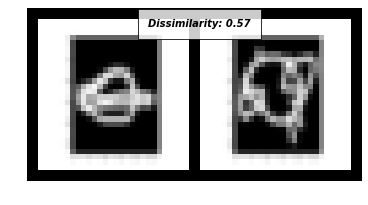

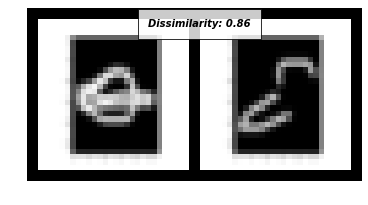

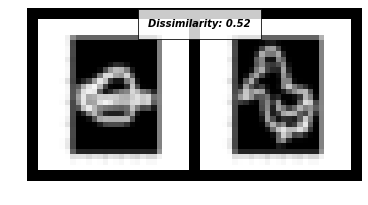

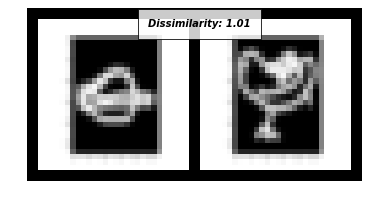

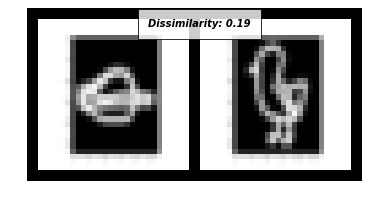

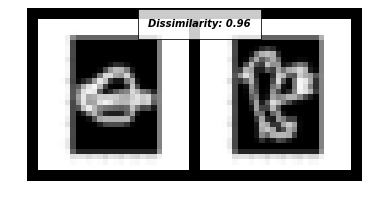

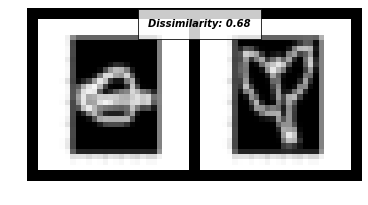

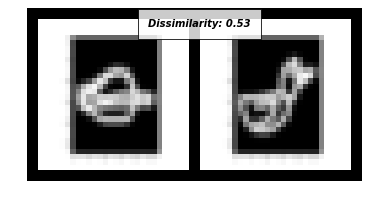

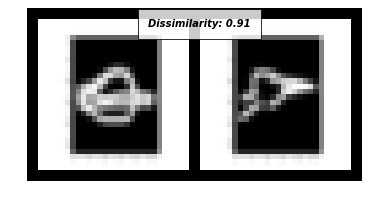

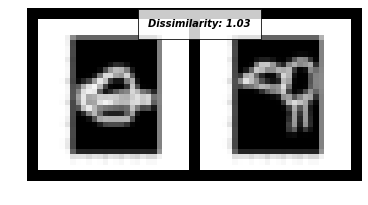

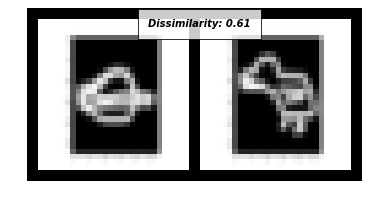

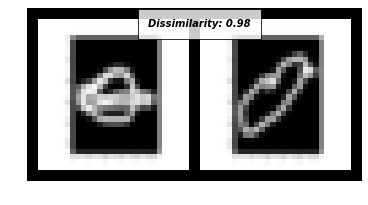

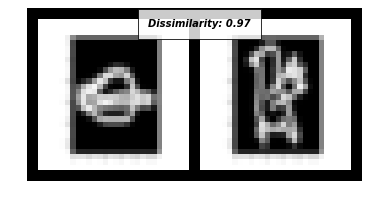

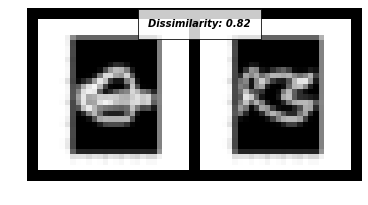

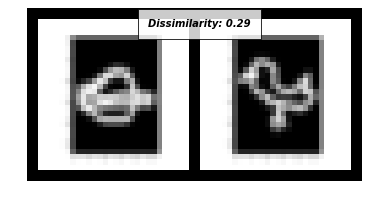

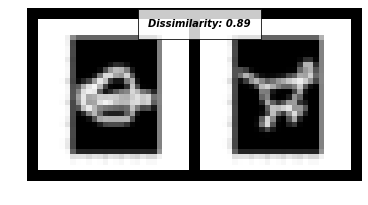

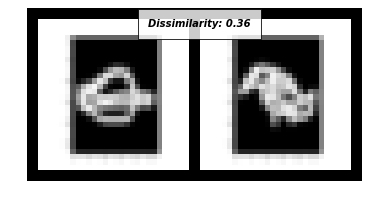

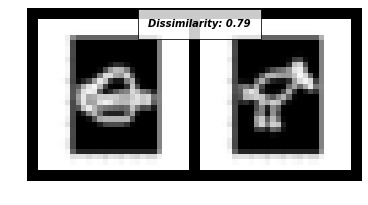

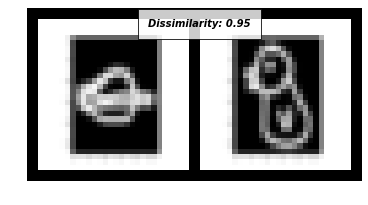

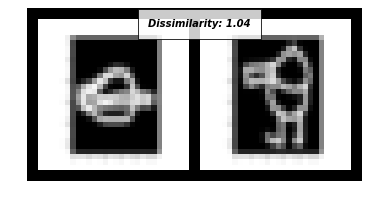

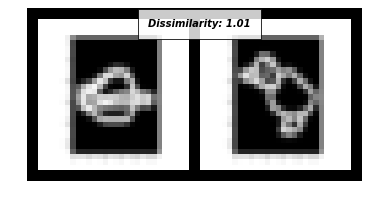

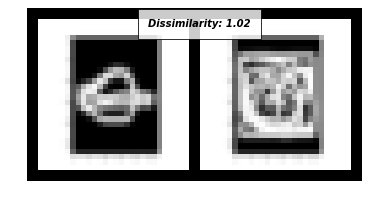

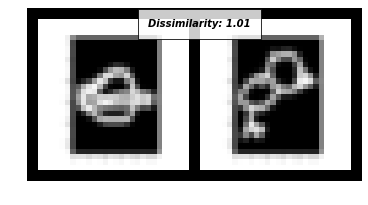

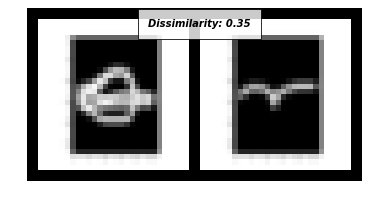

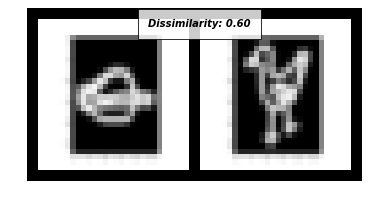

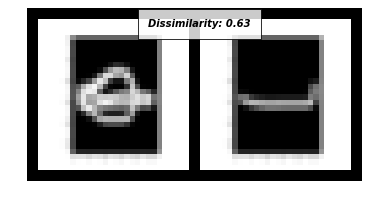

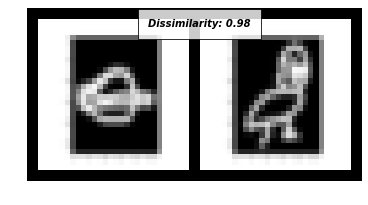

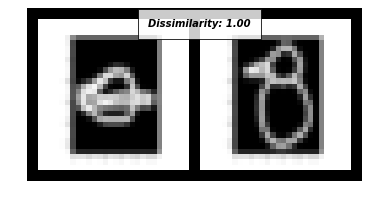

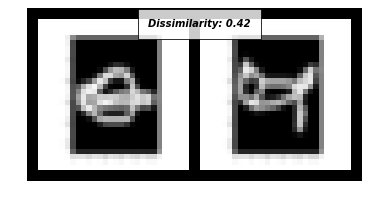

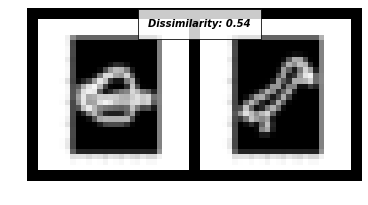

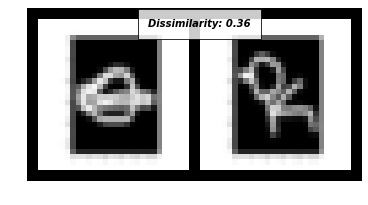

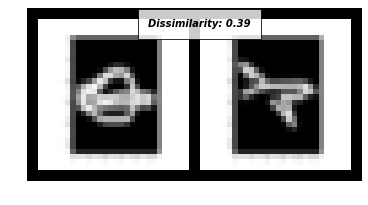

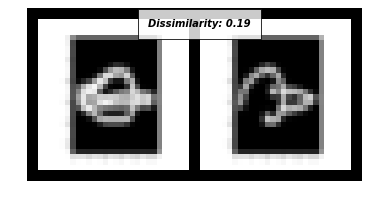

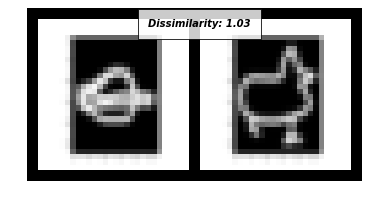

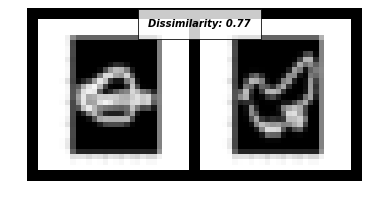

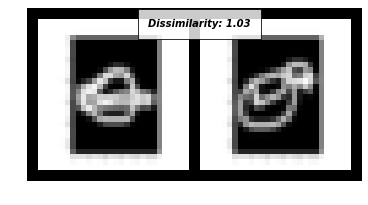

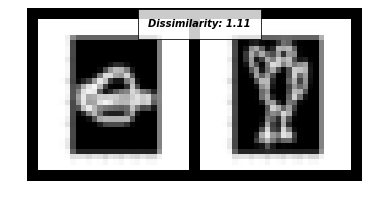

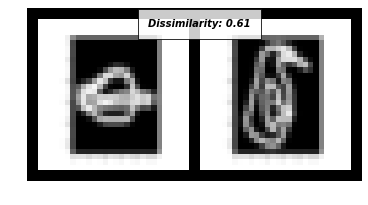

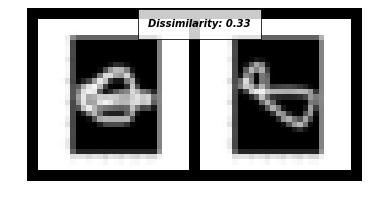

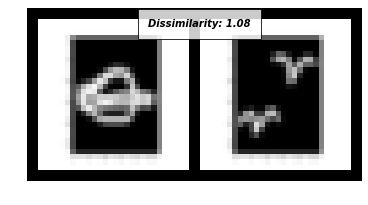

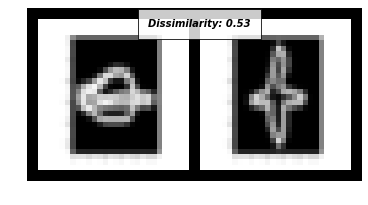

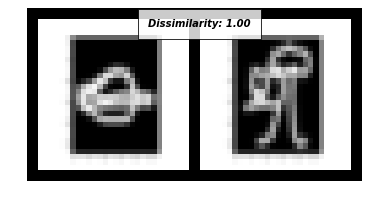

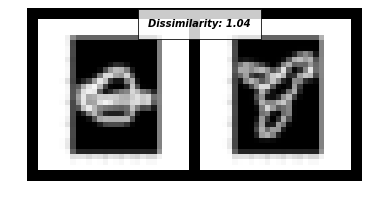

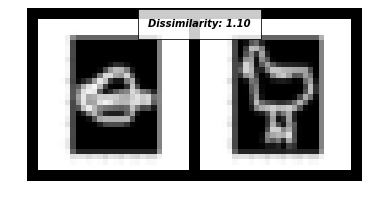

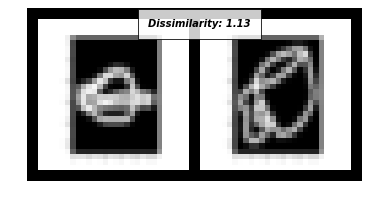

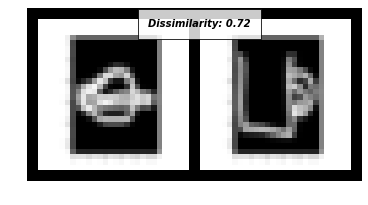

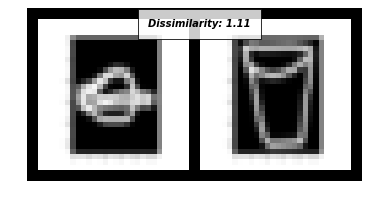

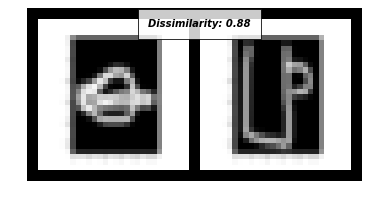

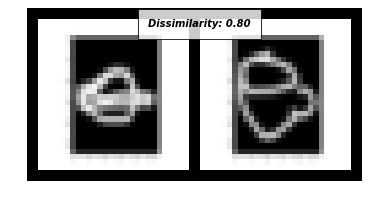

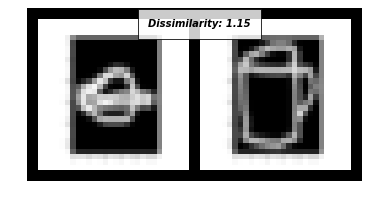

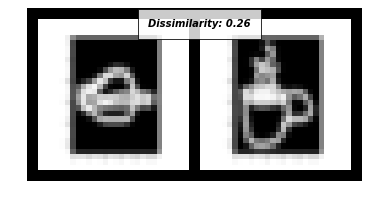

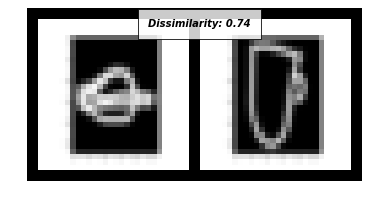

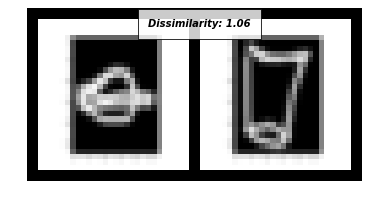

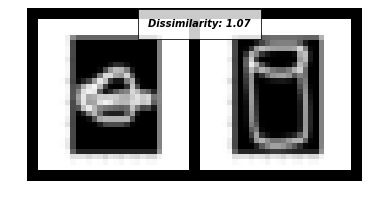

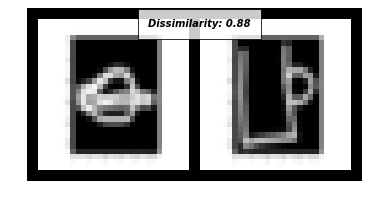

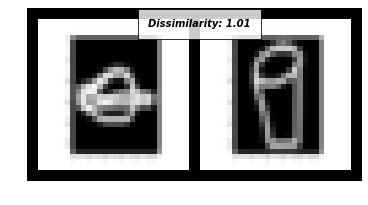

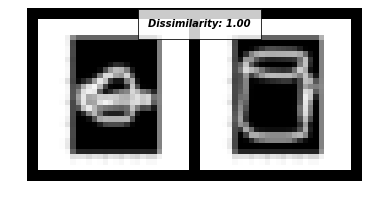

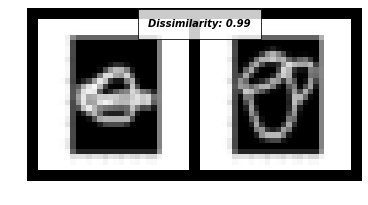

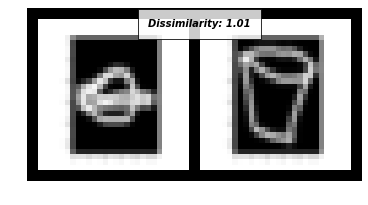

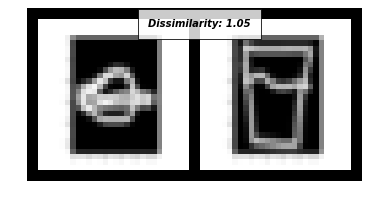

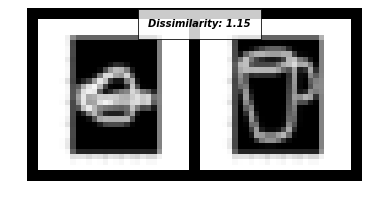

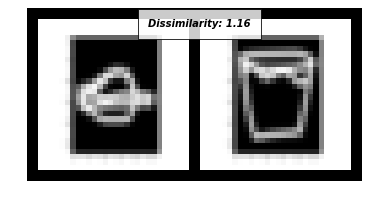

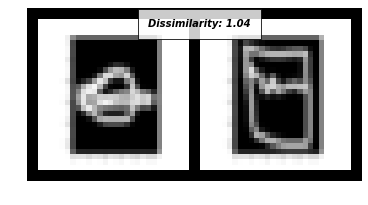

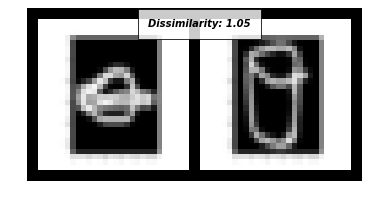

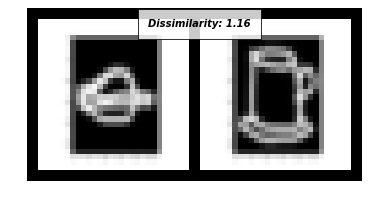

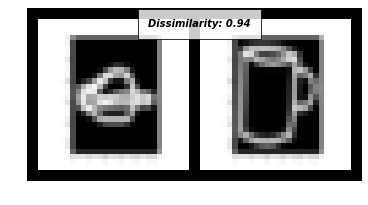

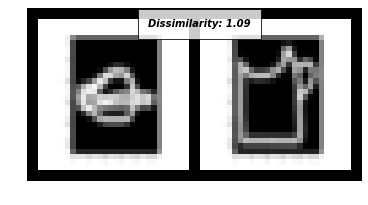

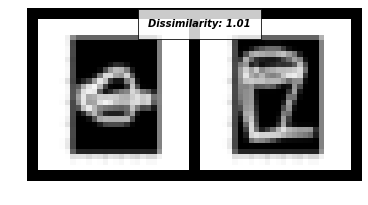

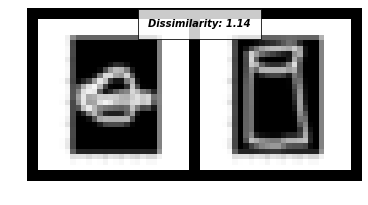

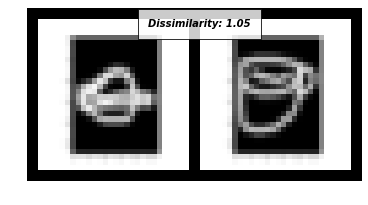

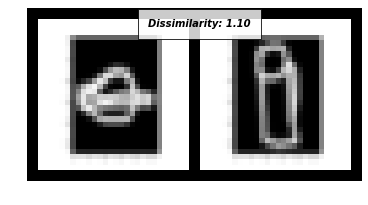

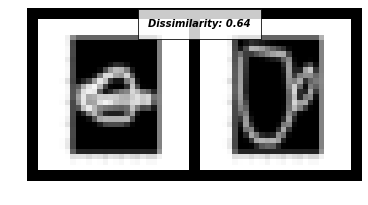

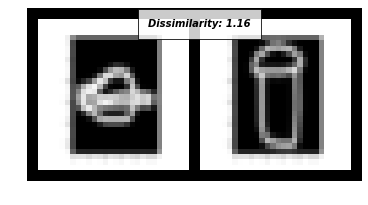

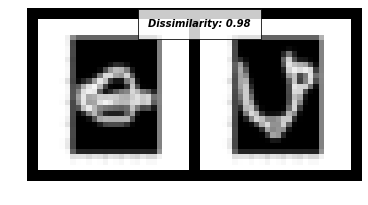

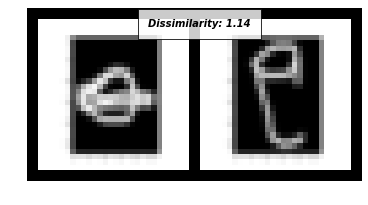

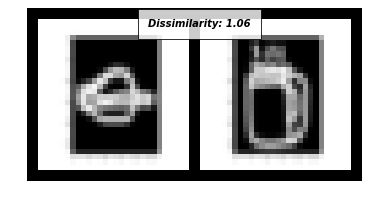

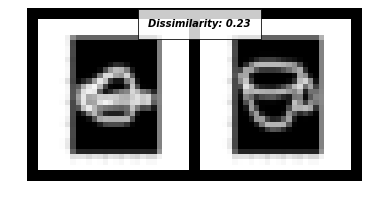

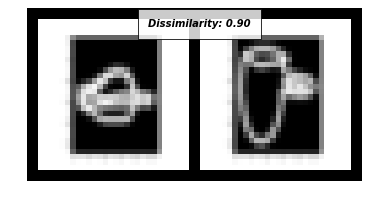

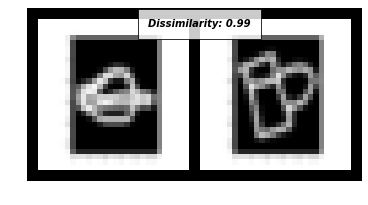

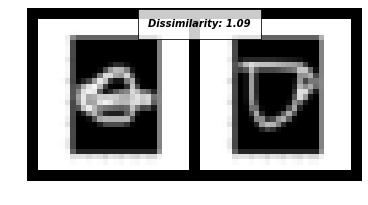

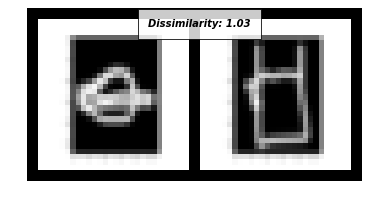

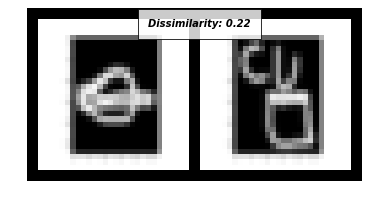

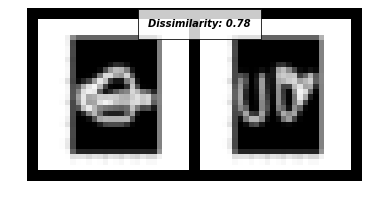

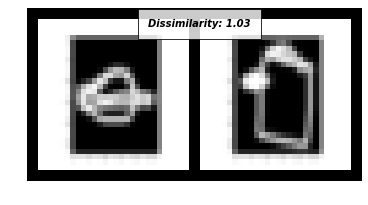

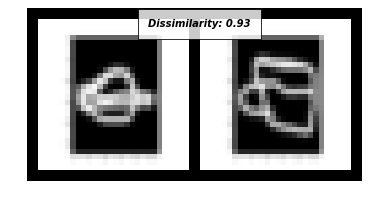

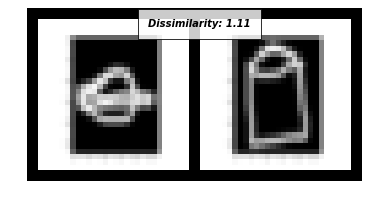

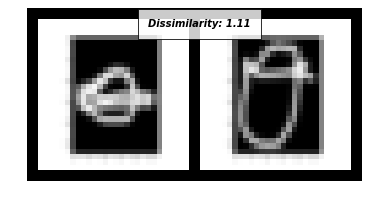

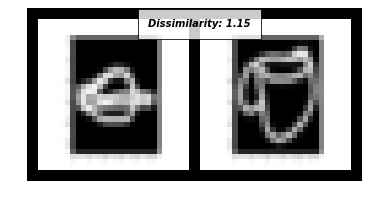

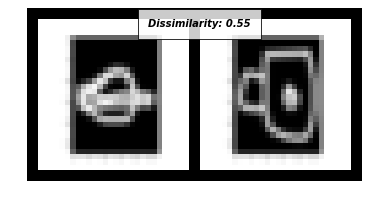

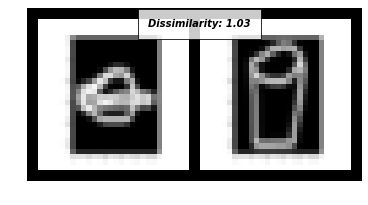

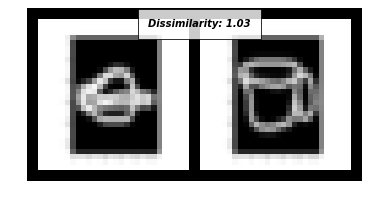

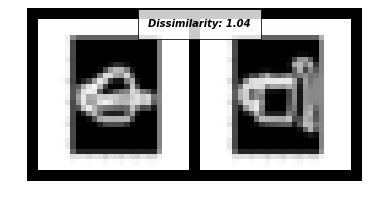

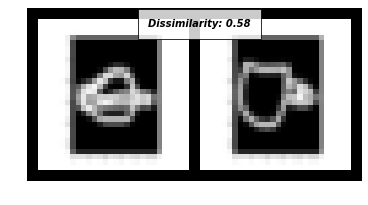

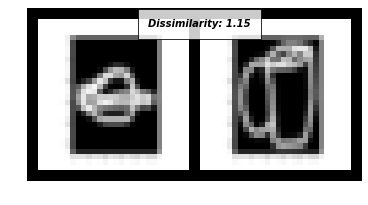

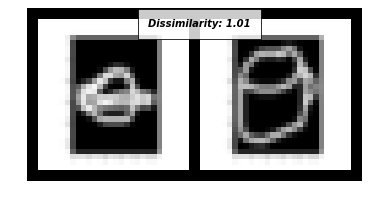

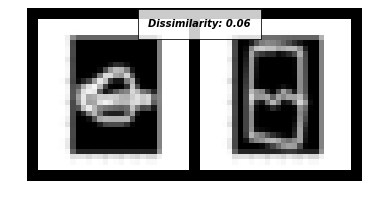

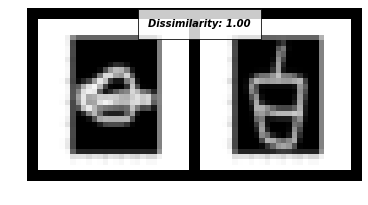

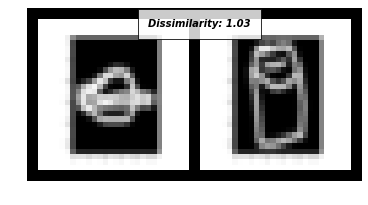

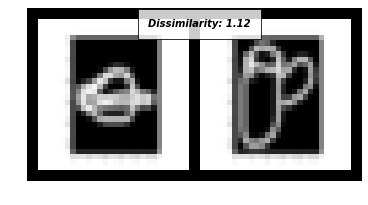

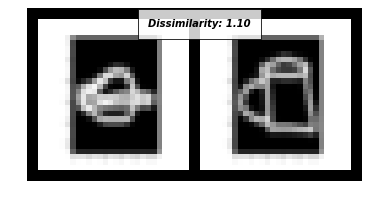

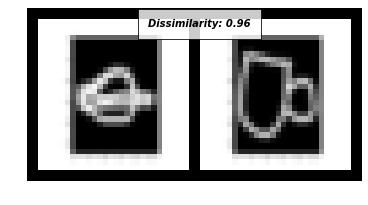

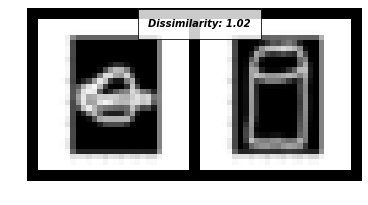

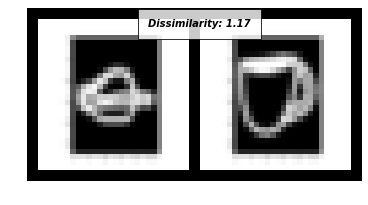

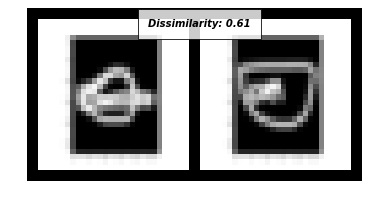

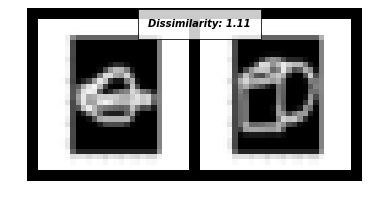

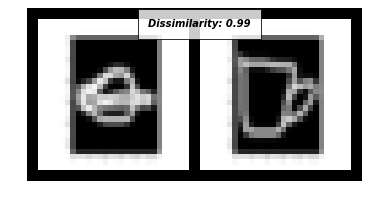

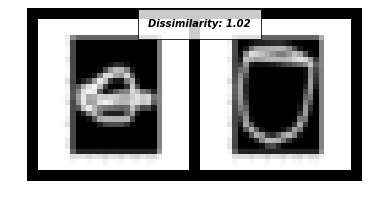

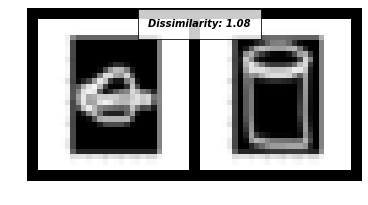

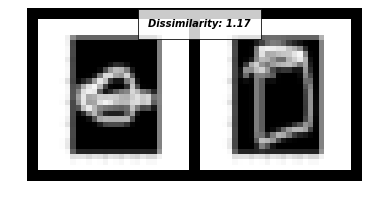

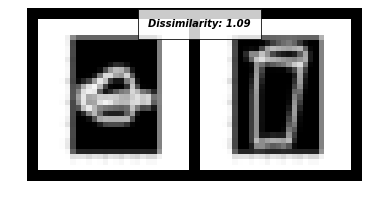

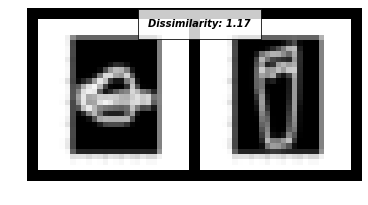

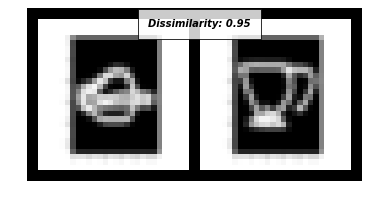

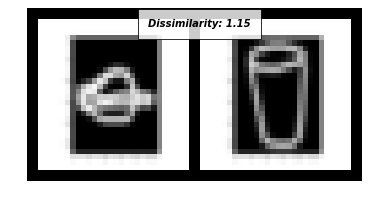

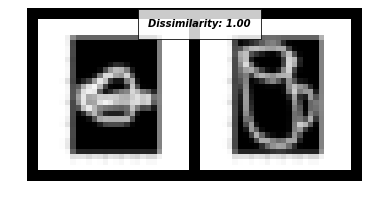

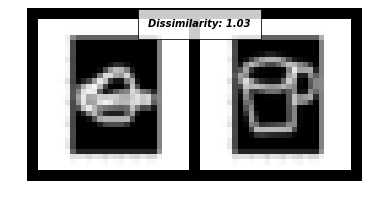

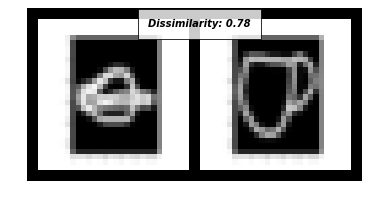

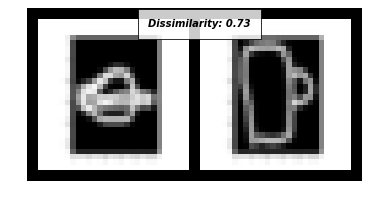

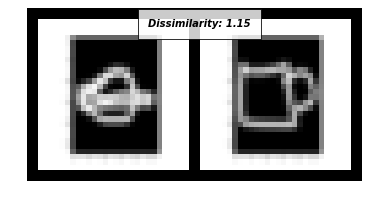

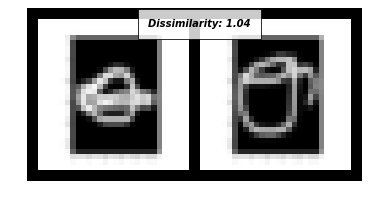

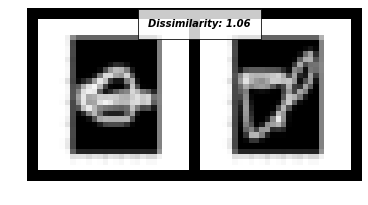

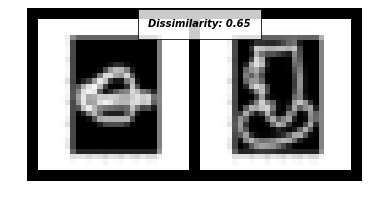

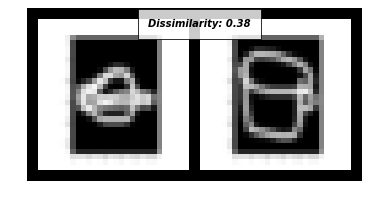

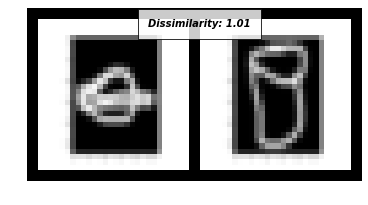

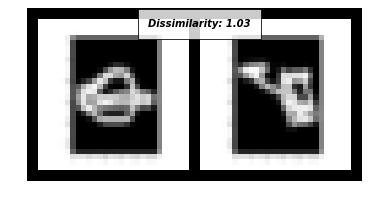

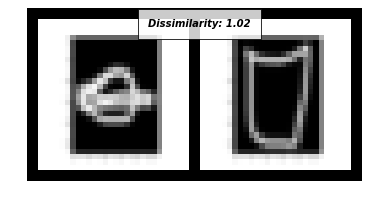

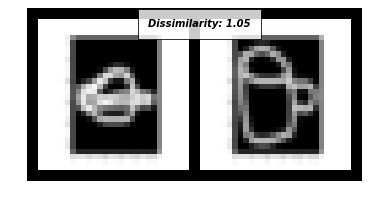

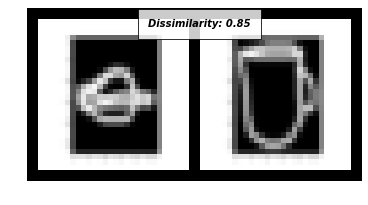

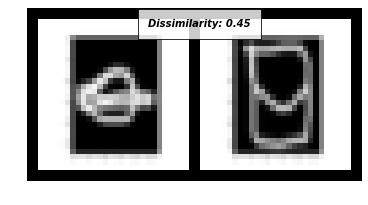

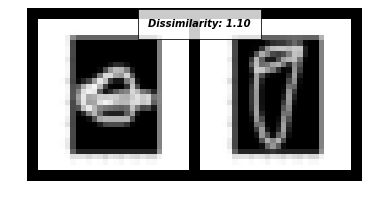

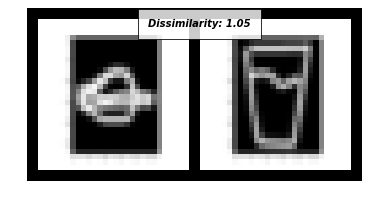

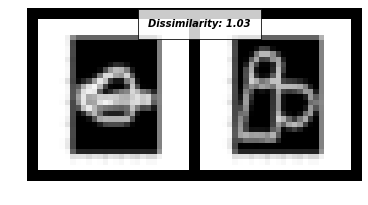

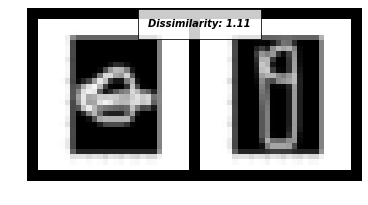

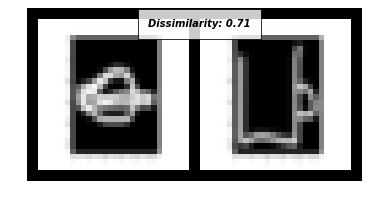

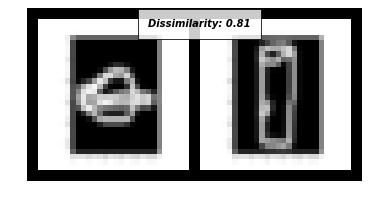

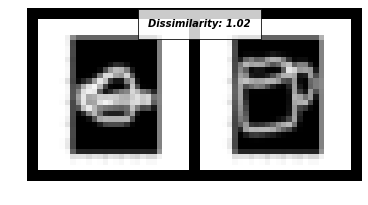

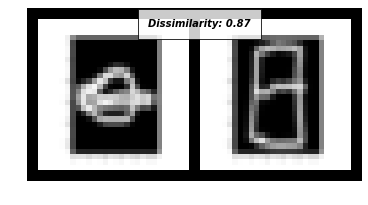

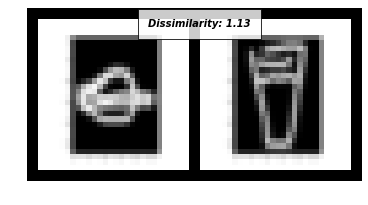

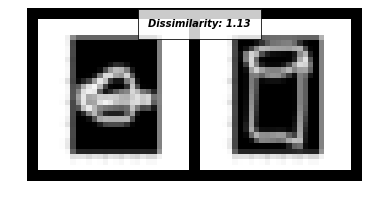

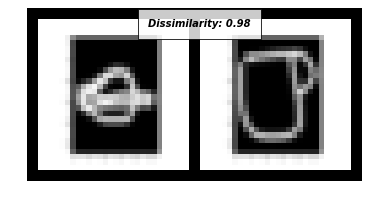

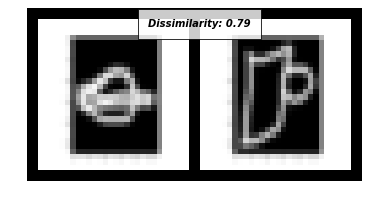

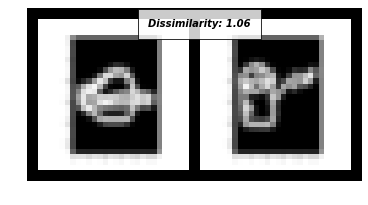

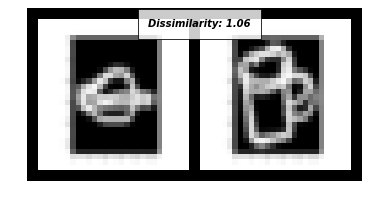

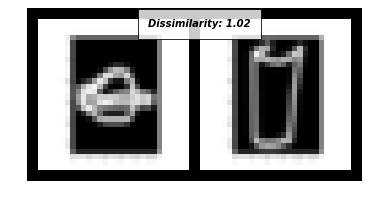

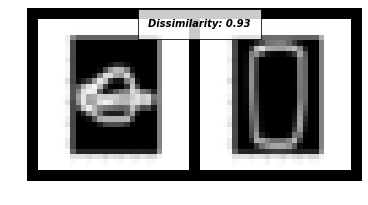

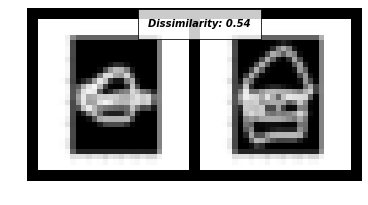

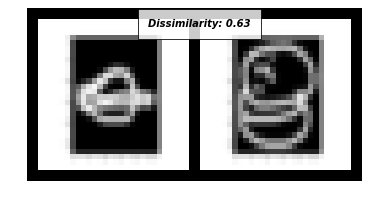

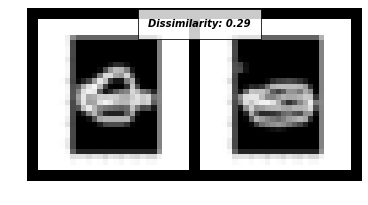

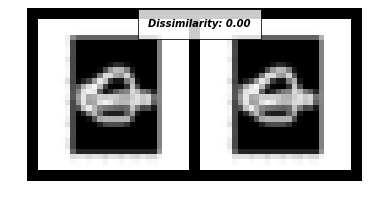

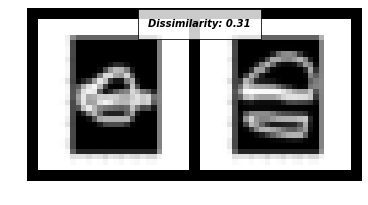

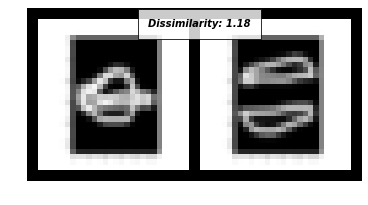

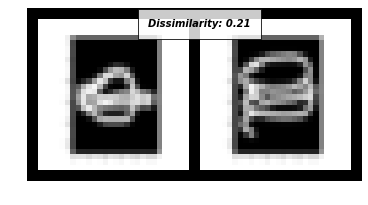

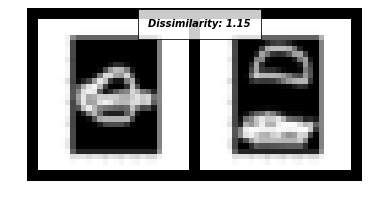

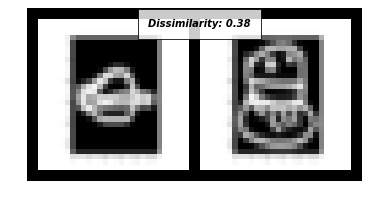

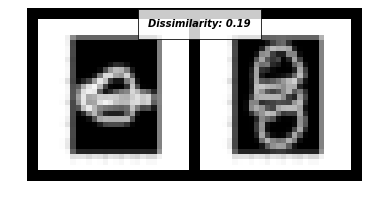

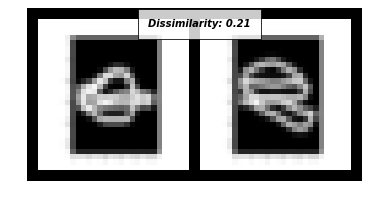

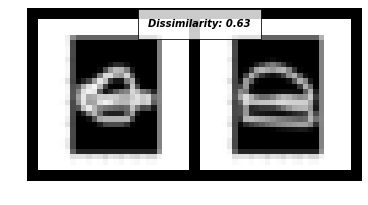

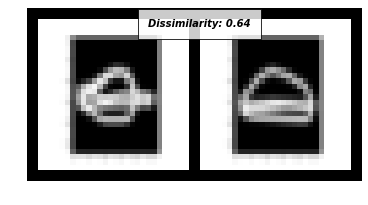

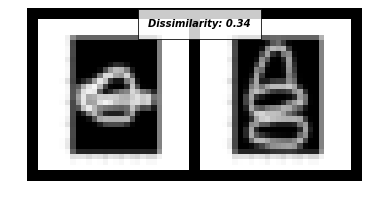

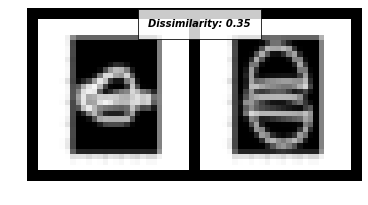

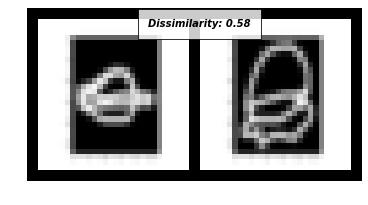

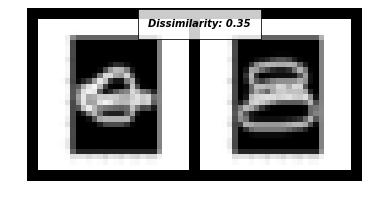

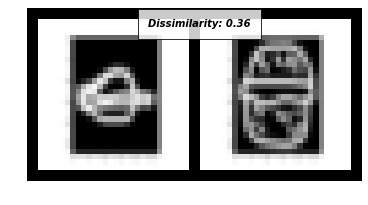

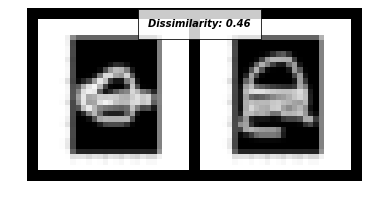

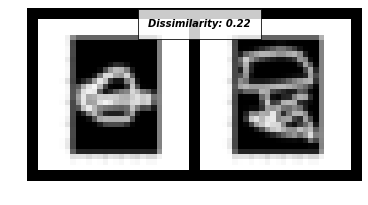

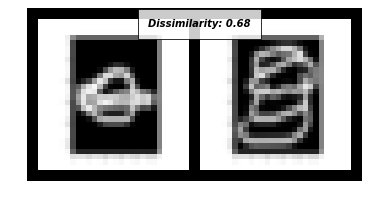

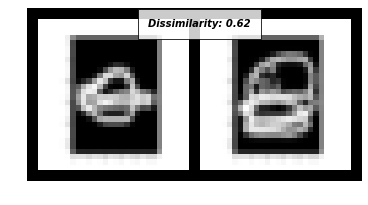

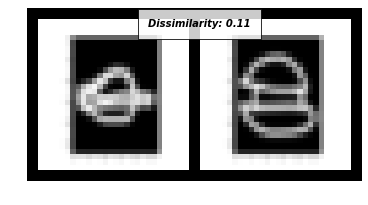

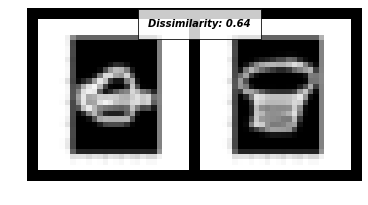

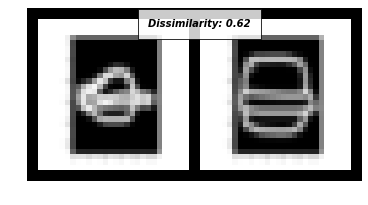

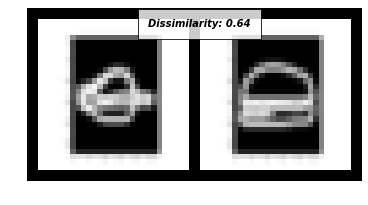

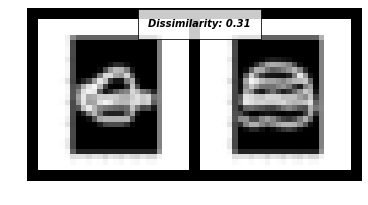

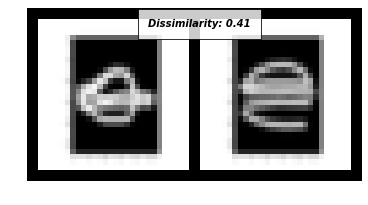

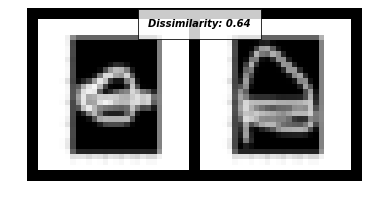

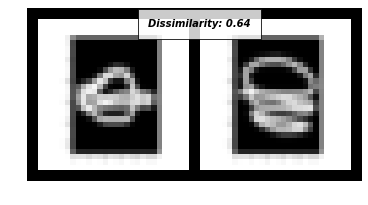

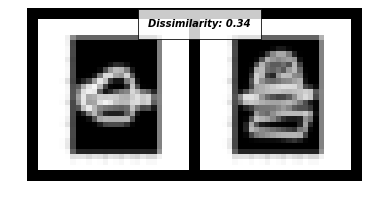

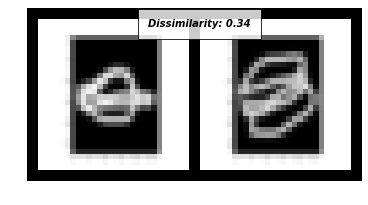

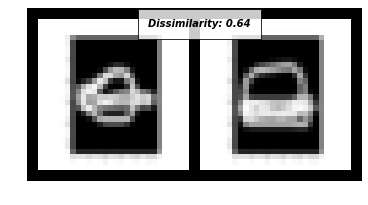

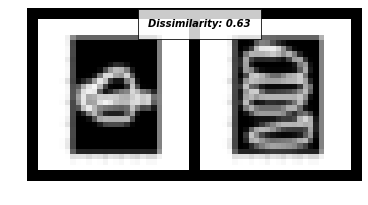

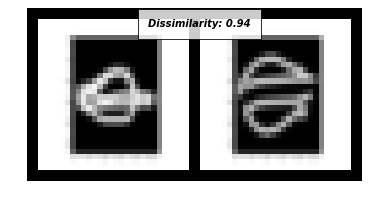

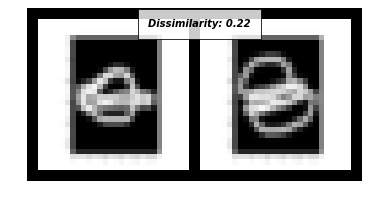

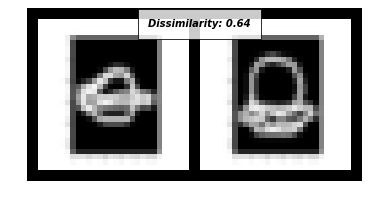

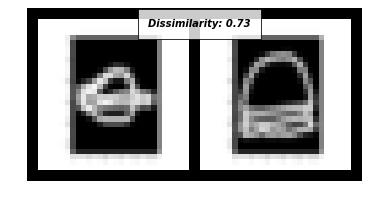

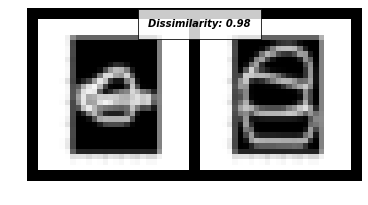

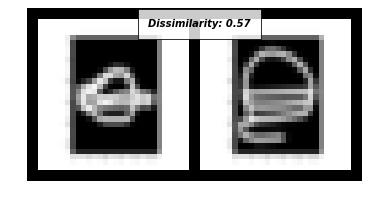

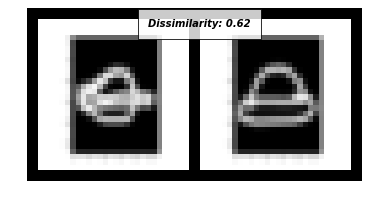

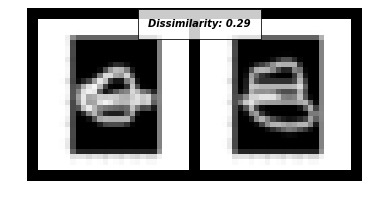

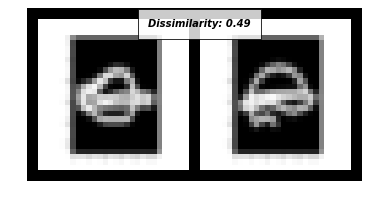

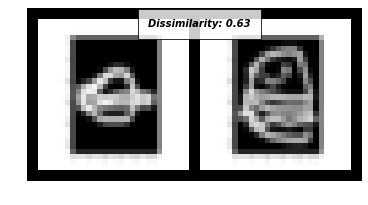

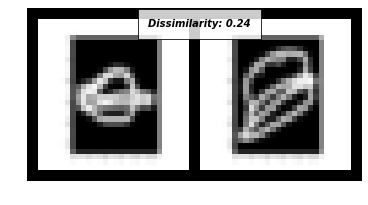

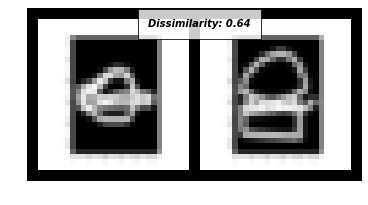

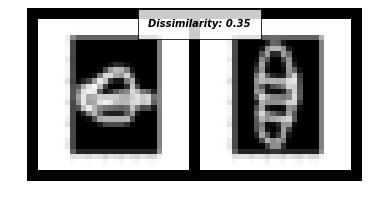

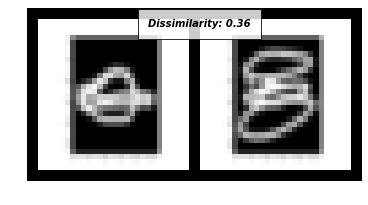

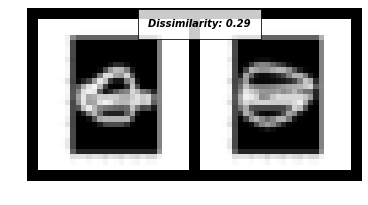

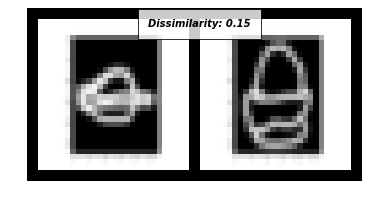

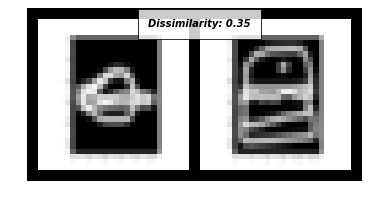

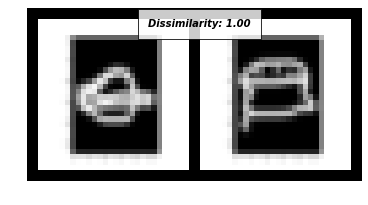

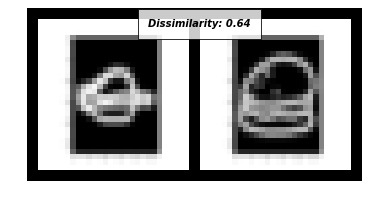

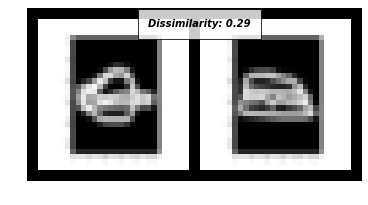

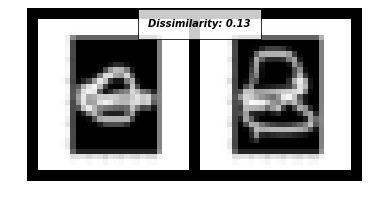

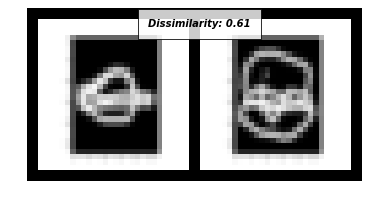

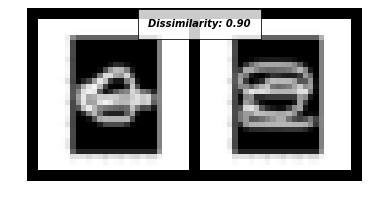

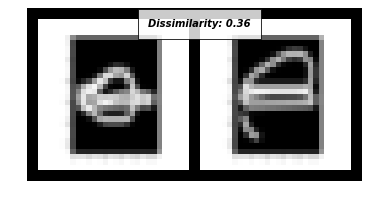

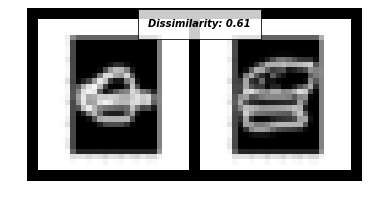

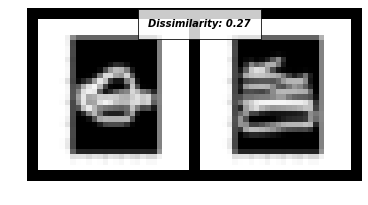

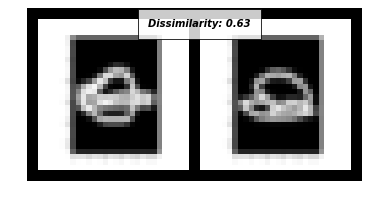

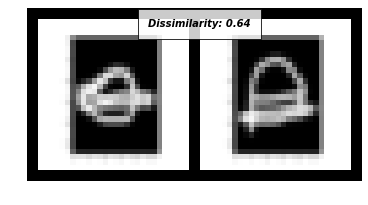

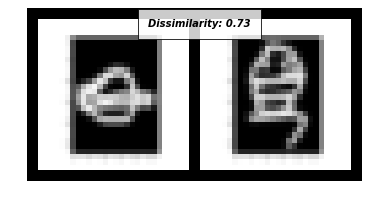

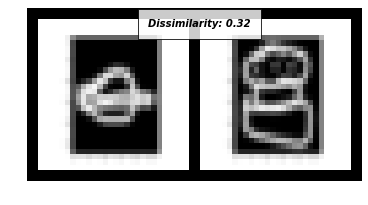

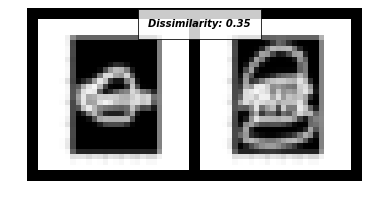

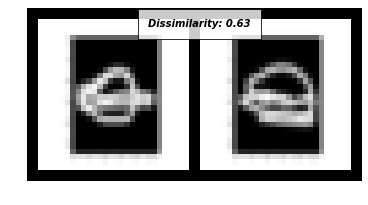

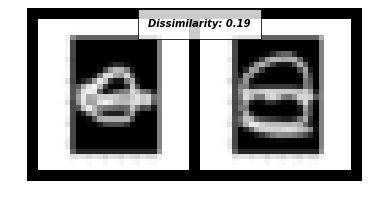

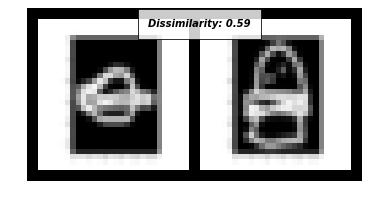

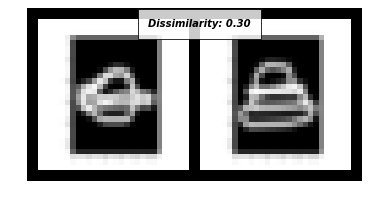

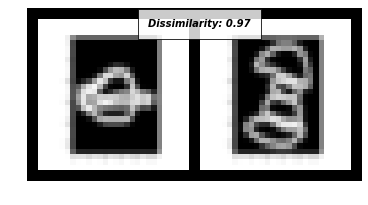

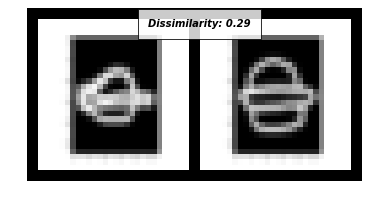

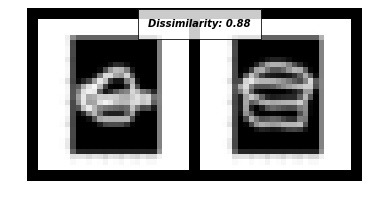

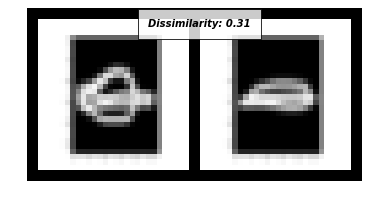

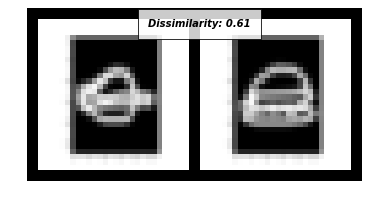

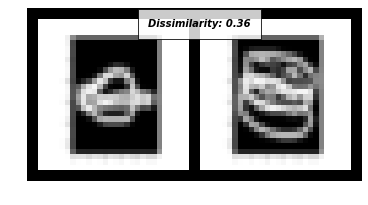

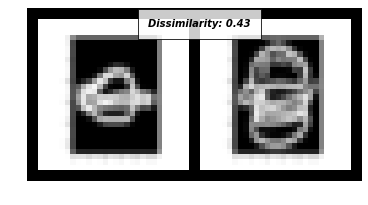

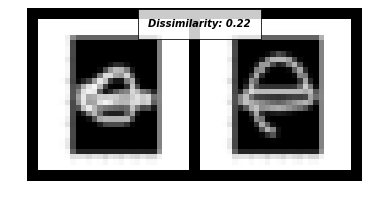

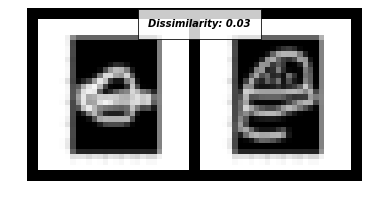

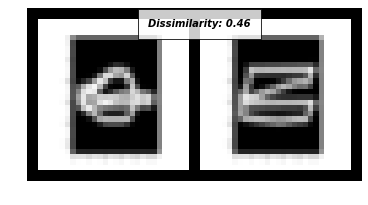

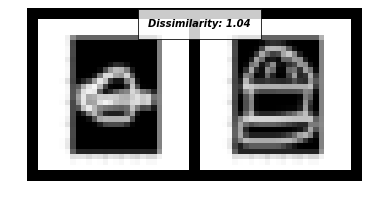

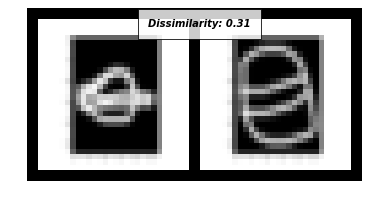

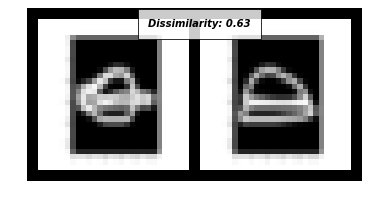

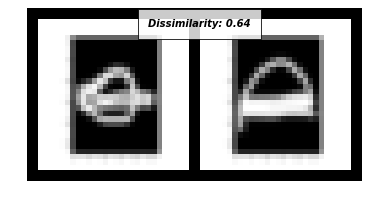

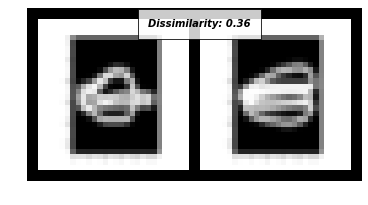

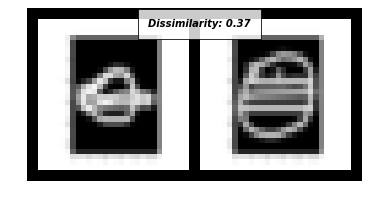

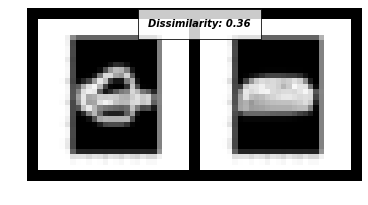

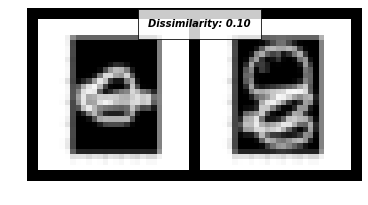

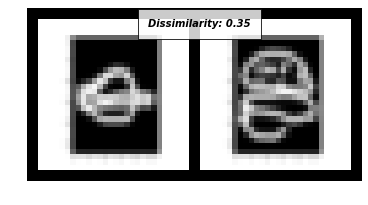

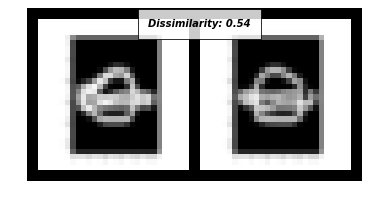

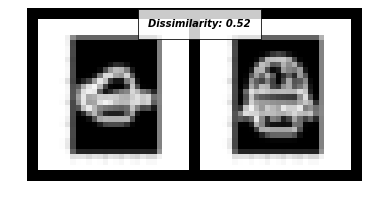

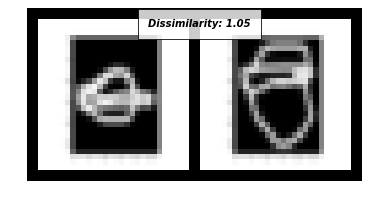

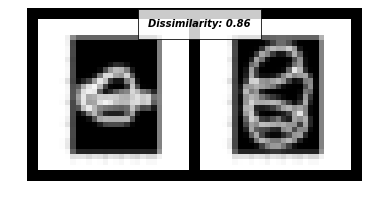

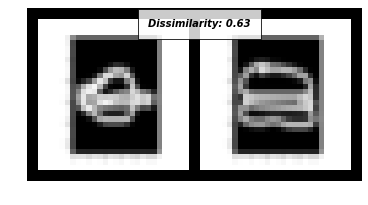

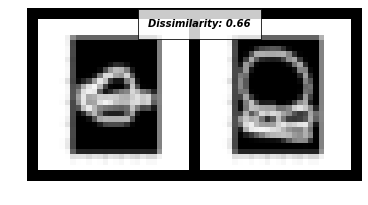

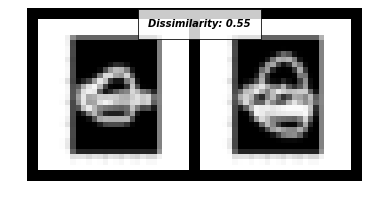

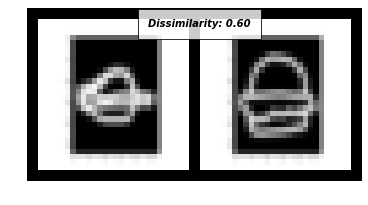

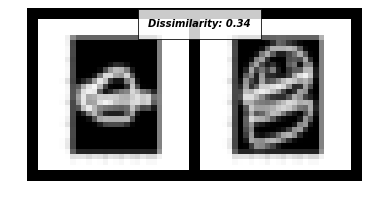

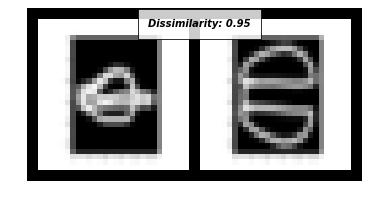

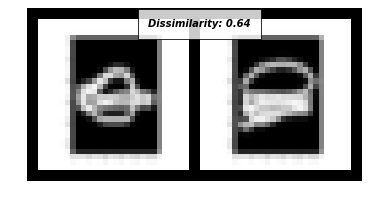

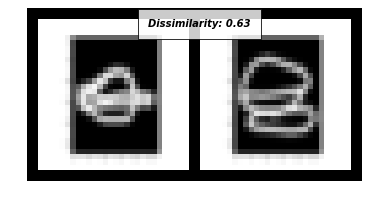

In [0]:
testlabels = np.zeros((5,100))
pigpath = './test_pic/testd/'
housepath = './test_pic/testh/'
birdpath = './test_pic/testb/'
cuppath = './test_pic/testc/'
hamburgerpath = './test_pic/testhb/'
pic = '%d.png'
folders = [pigpath,housepath,birdpath,cuppath,hamburgerpath]
selectedcases = np.array([1,2,3,5,4])#our selected cases
p = transforms.Compose([transforms.Resize((28, 28)),transforms.ToTensor()])
for k in range(5):#for A compared with all other cases
    f = folders[k]
    for i in range(100):#travel over all cases in A        
        x1 = Image.open((f+pic)%(i+1))
        x1 = x1.convert("L")
        x1 = p(x1)
        x1 = x1.unsqueeze(0)
        testresultfori = np.zeros((5,))
        
        for j in range(5):#for five classes of B
            x0 = Image.open((folders[j]+pic)%(selectedcases[j]))
            x0 = x0.convert("L")
            x0 = p(x0)
            x0 = x0.unsqueeze(0)
            concatenated = torch.cat((x0,x1),0)   
            output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
            euclidean_distance = F.pairwise_distance(output1, output2)
            testresultfori[j] = euclidean_distance
        testlabels[k,i] = np.argmin(testresultfori)
        imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [0]:
np.save('labels', testlabels)

ModuleNotFoundError: No module named 'seaborn'

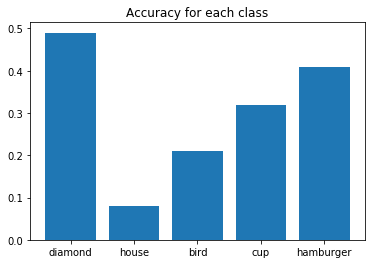

In [0]:
'''.............................Visualization...............................'''
X1 = ['diamond','house','bird','cup','hamburger']
Y=np.zeros((5,))
for i in range(5):
    Y[i] = testlabels[i,testlabels[i,:] == i].shape[0]/testlabels[i,:].shape[0]

plt.bar(X1,Y)
plt.title('Accuracy for each class')

import seaborn as sns; sns.set()
corr = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        corr[i,j] = testlabels[i,testlabels[i,:] == j].shape[0]
ax = sns.heatmap(corr,linewidths=0.1,vmax=1.0,square=True,linecolor='white',annot=True,cmap='coolwarm')